In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math

pd.options.display.max_columns = 25

In [26]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price # 10块钱
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [27]:
# ----- READ IN DATA -----
df = pd.read_csv('subscriber_data.csv')
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

In [9]:
df

obs_id       age    income     hours  female  churn_TF
0          0  1.078621 -1.406551  2.076086     0.0       0.0
1          1 -0.316238  1.609010  0.190891     1.0       1.0
2          2  0.659451 -0.142910  0.414028     0.0       1.0
3          3  0.868265 -0.314656 -0.926715     1.0       0.0
4          4 -0.159856  0.243120 -0.788569     0.0       1.0
...      ...       ...       ...       ...     ...       ...
9995    9995 -0.598808  0.989642  0.667830     0.0       0.0
9996    9996 -1.691307  0.281501 -0.298833     1.0       1.0
9997    9997  0.864473  0.691871  0.815441     0.0       1.0
9998    9998  0.073726  0.009321 -0.820586     0.0       1.0
9999    9999  1.002217 -0.215040  1.021014     0.0       0.0

[10000 rows x 6 columns]

In [28]:
# ----- FIT CHURN MODEL ------
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = ['age', 'income', 'hours', 'female']    # list of x covariates
add_constant_TF = True

# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())

# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     231.8
Date:                Tue, 06 Dec 2022   Prob (F-statistic):          3.50e-187
Time:                        13:12:48   Log-Likelihood:                -4558.3
No. Observations:                7000   AIC:                             9127.
Df Residuals:                    6995   BIC:                             9161.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.13

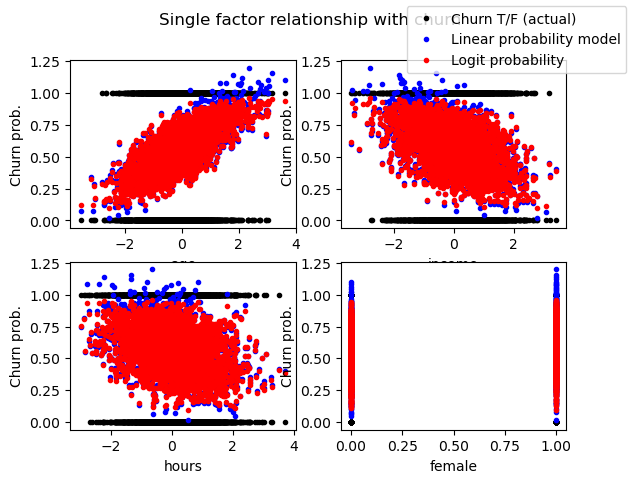

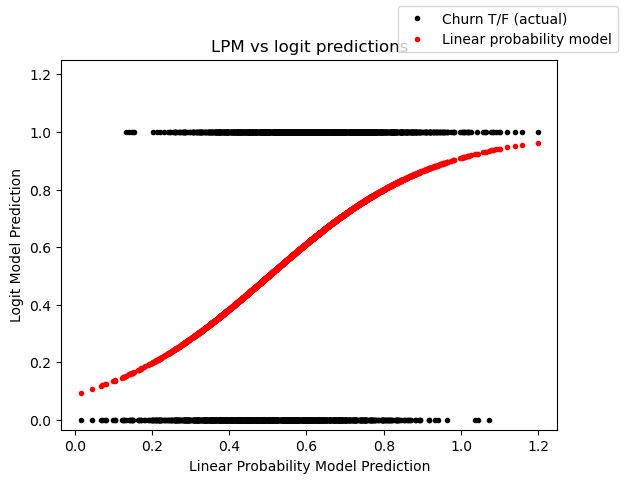

In [29]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.suptitle('Single factor relationship with churn')

for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(df_test[select_coef], df_test['churn_TF'], 'k.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn_TF']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [15]:
df_test

const  obs_id       age    income     hours  female  churn_TF  \
9775    1.0    9775  0.903021 -0.066866 -0.481617     0.0       1.0   
6752    1.0    6752 -0.160646  0.759936 -0.203481     0.0       1.0   
3640    1.0    3640 -0.991553  1.049142 -0.775790     1.0       0.0   
1864    1.0    1864  2.560691 -0.351899 -0.944929     0.0       1.0   
4593    1.0    4593 -0.134495  0.648658 -0.260840     0.0       0.0   
...     ...     ...       ...       ...       ...     ...       ...   
3356    1.0    3356 -0.392870 -0.028515 -0.195779     0.0       0.0   
6867    1.0    6867  0.078098  1.583233  0.658542     0.0       0.0   
2062    1.0    2062 -1.690823 -0.497183  0.529766     1.0       1.0   
3876    1.0    3876  0.105693 -0.660075  0.177115     0.0       0.0   
3009    1.0    3009  0.802572 -0.278351 -0.183117     1.0       0.0   

      prob_churn_lpm  prob_churn_logit  random_draws  price_no_offer  \
9775        0.685073          0.700683      0.129497               0   
6752        0.463819          0.456878      0.733670               0   
3640        0.443851          0.434040      0.310053              10   
1864        0.949794          0.888425      0.726264               0   
4593        0.479868          0.475343      0.903929              10   
...              ...               ...           ...             ...   
3356        0.498002          0.496357      0.102958              10   
6867        0.372882          0.355996      0.117500              10   
2062        0.398444          0.383788      0.408592               0   
3876        0.589965          0.601445      0.919680              10   
3009        0.744735          0.755405      0.182622              10   

      accept_offer_prob  would_accept_offer_rand_draw  make_offer_lpm  \
9775                0.3                          True            True   
6752                0.3                         False           False   
3640                1.0                          True           False   
1864                0.3                         False            True   
4593                1.0                          True           False   
...                 ...                           ...             ...   
3356                1.0                          True           False   
6867                1.0                          True           False   
2062                0.3                         False           False   
3876                1.0                          True            True   
3009                1.0                          True            True   

      accept_offer_lpm  price_lpm_offer  make_offer_logit  accept_offer_logit  \
9775              True                7              True                True   
6752             False                0             False               False   
3640             False               10             False               False   
1864             False                0              True               False   
4593             False               10             False               False   
...                ...              ...               ...                 ...   
3356             False               10             False               False   
6867             False               10             False               False   
2062             False                0             False               False   
3876              True                7              True                True   
3009              True                7              True                True   

      price_logit_offer  
9775                  7  
6752                  0  
3640                 10  
1864                  0  
4593                 10  
...                 ...  
3356                 10  
6867                 10  
2062                  0  
3876                  7  
3009                  7  

[3000 rows x 19 columns]

In [40]:
df_test['accept_offer_prob'].value_counts()

0.3    1691
1.0    1309
Name: accept_offer_prob, dtype: int64

In [21]:
(df_test['random_draws'] < df_test['accept_offer_prob']).value_counts()

True     1804
False    1196
dtype: int64

In [23]:
# Before offer
# Non churner: 
# Churner would stay:
# Churner would not stay:

0.39866666666666667

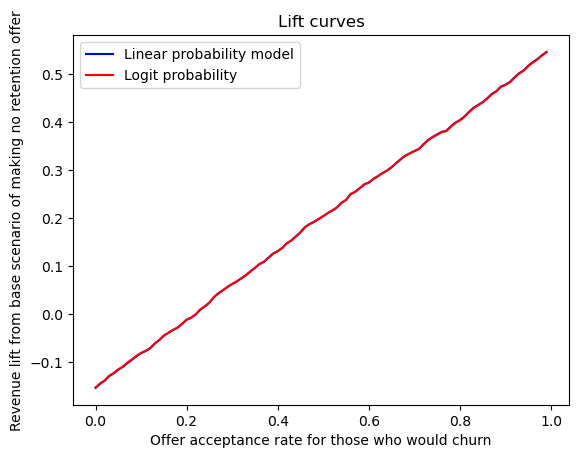

In [39]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [41]:
df_impact

subs revenue lift_from_no_offer
no_offer     1309   13090                0.0
lpm_offer    1715   13904           0.062185
logit_offer  1713   13902           0.062032

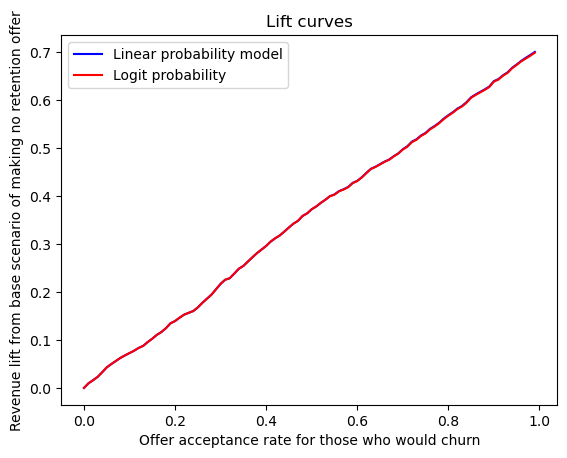

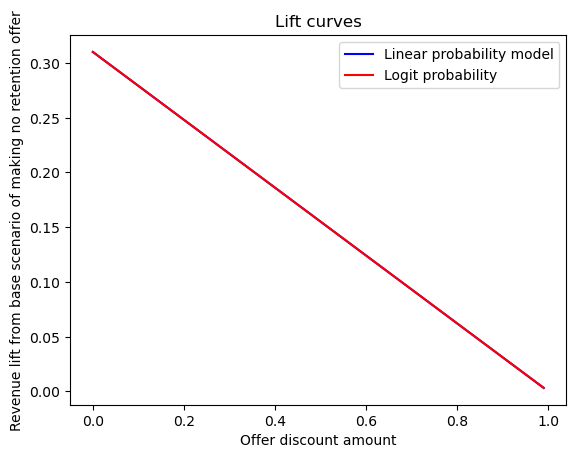

In [35]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 0
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [36]:
df_impact

subs revenue lift_from_no_offer
no_offer     1309   13090                0.0
lpm_offer    1715   15932           0.217112
logit_offer  1715   15932           0.217112

In [37]:
df_test

const  obs_id       age    income     hours  female  churn_TF  \
5461    1.0    5461 -2.155591 -0.523820 -0.210729     0.0       0.0   
8807    1.0    8807  0.938753 -0.330109  1.169634     0.0       0.0   
1704    1.0    1704  0.464219  0.159356 -1.069586     0.0       1.0   
1008    1.0    1008 -1.373282 -0.064059  0.192502     1.0       0.0   
7471    1.0    7471  0.797242  0.888734  0.495632     1.0       1.0   
...     ...     ...       ...       ...       ...     ...       ...   
4118    1.0    4118 -0.140272 -0.252824 -0.646901     0.0       1.0   
5026    1.0    5026 -0.490116  0.253964  0.291213     0.0       0.0   
1839    1.0    1839 -0.327744 -0.243333  0.802734     0.0       0.0   
6084    1.0    6084  0.054907  0.596067  0.765758     1.0       0.0   
391     1.0     391 -0.673192 -1.228835 -0.894260     0.0       1.0   

      prob_churn_lpm  prob_churn_logit  random_draws  price_no_offer  \
5461        0.321122          0.302452      0.830940              10   
8807        0.623326          0.637676      0.535579              10   
1704        0.655474          0.671590      0.759880               0   
1008        0.428286          0.416191      0.817310              10   
7471        0.611104          0.624462      0.442748               0   
...              ...               ...           ...             ...   
4118        0.586369          0.597471      0.897485               0   
5026        0.441151          0.430469      0.161820              10   
1839        0.473558          0.467695      0.924211              10   
6084        0.523161          0.525143      0.971200              10   
391         0.614957          0.629196      0.456753               0   

      accept_offer_prob  would_accept_offer_rand_draw  make_offer_lpm  \
5461                0.0                         False           False   
8807                0.0                         False            True   
1704                0.3                         False            True   
1008                0.0                         False           False   
7471                0.3                         False            True   
...                 ...                           ...             ...   
4118                0.3                         False            True   
5026                0.0                         False           False   
1839                0.0                         False           False   
6084                0.0                         False            True   
391                 0.3                         False            True   

      accept_offer_lpm  price_lpm_offer  make_offer_logit  accept_offer_logit  \
5461             False               10             False               False   
8807             False               10              True               False   
1704             False                0              True               False   
1008             False               10             False               False   
7471             False                0              True               False   
...                ...              ...               ...                 ...   
4118             False                0              True               False   
5026             False               10             False               False   
1839             False               10             False               False   
6084             False               10              True               False   
391              False                0              True               False   

      price_logit_offer  
5461                 10  
8807                 10  
1704                  0  
1008                 10  
7471                  0  
...                 ...  
4118                  0  
5026                 10  
1839                 10  
6084                 10  
391                   0  

[3000 rows x 19 columns]

In [38]:
df_test['accept_offer_prob'].value_counts()

0.3    1691
0.0    1309
Name: accept_offer_prob, dtype: int64

In [77]:
def impact_test(df_test, acceptance_rate_nonchurn=1, acceptance_rate_churn=0.3, threshold=0.5, discount_amount=0.3):
    # ----- TEST RETENTION OFFER SCENARIOS -----
    # evaluate the impact of an offer
    acceptance_rate_nonchurn = acceptance_rate_nonchurn
    acceptance_rate_churn = acceptance_rate_churn
    threshold = threshold
    base_price = 10
    discount_amount = discount_amount
    cases = ['no_offer', 'lpm_offer', 'logit_offer']

    # draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
    df_test['random_draws'] = np.random.random(df_test.shape[0])

    # base assessment
    df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    # test sensitivity to thresholds
    df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
    for t_ind in df_lift_threshold.index:
        t_threshold = t_ind / 100
        _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

        df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
        df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
    del t_df_impact, t_threshold, t_ind

    # test sensitivity to acceptance rate for churners
    df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
    for t_ind in df_lift_acceptance_rate_churn.index:
        t_acceptance_rate_churn = t_ind / 100
        _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

        df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
        df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
    del t_df_impact, t_acceptance_rate_churn, t_ind

    # test sensitivity to offer discount amount
    df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
    for t_ind in df_lift_discount_amount.index:
        t_discount_amount = t_ind / 100
        _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

        df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
        df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
    del t_df_impact, t_discount_amount, t_ind

    # --- plot lift curves
    # Threshold sensitivity
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
    ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
    plt.title('Lift curves')
    plt.xlabel('Threshold probability for predicting customer churns')
    plt.ylabel('Revenue lift from base scenario of making no retention offer')
    plt.legend(labels=['Linear probability model', 'Logit probability'])

    # Acceptance rate sensitivity
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
    ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
    plt.title('Lift curves')
    plt.xlabel('Offer acceptance rate for those who would churn')
    plt.ylabel('Revenue lift from base scenario of making no retention offer')
    plt.legend(labels=['Linear probability model', 'Logit probability'])

    # Discount amount sensitivity
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
    ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
    plt.title('Lift curves')
    plt.xlabel('Offer discount amount')
    plt.ylabel('Revenue lift from base scenario of making no retention offer')
    plt.legend(labels=['Linear probability model', 'Logit probability'])
    
    plt.plot()
    
    no_offer = df_impact.iloc[0, :].to_frame().T.reset_index(drop=True)
    no_offer['acceptance_rate_nonchurn'] = acceptance_rate_nonchurn
    no_offer['acceptance_rate_churn'] = acceptance_rate_churn
    no_offer['threshold'] = threshold
    no_offer['discount_amount'] = discount_amount
    
    lpm_offer = df_impact.iloc[1, :].to_frame().T.reset_index(drop=True)
    lpm_offer['acceptance_rate_nonchurn'] = acceptance_rate_nonchurn
    lpm_offer['acceptance_rate_churn'] = acceptance_rate_churn
    lpm_offer['threshold'] = threshold
    lpm_offer['discount_amount'] = discount_amount
    
    logit_offer = df_impact.iloc[2, :].to_frame().T.reset_index(drop=True)
    logit_offer['acceptance_rate_nonchurn'] = acceptance_rate_nonchurn
    logit_offer['acceptance_rate_churn'] = acceptance_rate_churn
    logit_offer['threshold'] = threshold
    logit_offer['discount_amount'] = discount_amount
    
    return no_offer, lpm_offer, logit_offer

In [52]:
df_impact

subs revenue lift_from_no_offer
no_offer     1309   13090                0.0
lpm_offer    1705   15691           0.198701
logit_offer  1705   15691           0.198701

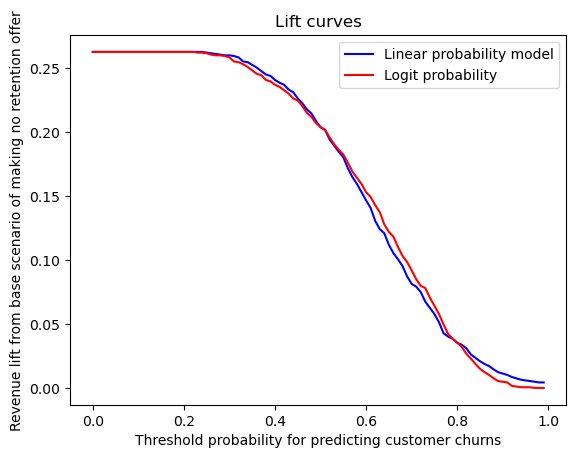

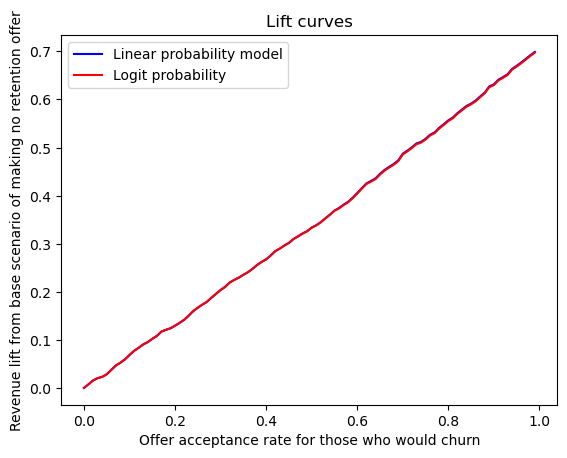

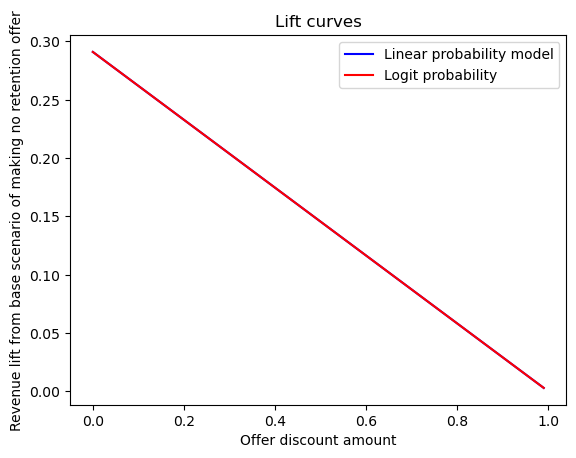

In [73]:
no, lpm, logit = impact_test(df_test, 0, 0.3, 0.5, 0.3)

THRESHOLD == 0.4

THRESHOLD == 0.45

THRESHOLD == 0.5

THRESHOLD == 0.55

THRESHOLD == 0.6

THRESHOLD == 0.6499999999999999



/var/folders/42/jjtp5rtx10ddt53ggkm3x1280000gn/T/ipykernel_67315/2321014217.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


THRESHOLD == 0.7

THRESHOLD == 0.75

THRESHOLD == 0.7999999999999999

THRESHOLD == 0.8499999999999999

THRESHOLD == 0.8999999999999999

THRESHOLD == 0.9499999999999998



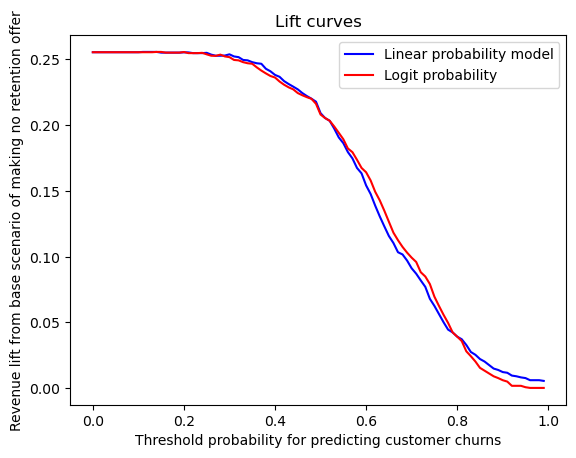

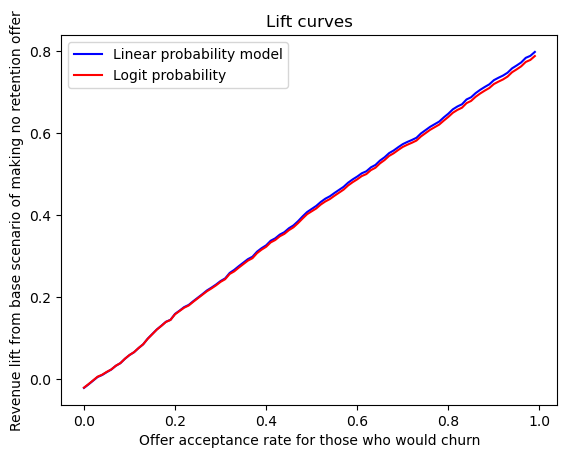

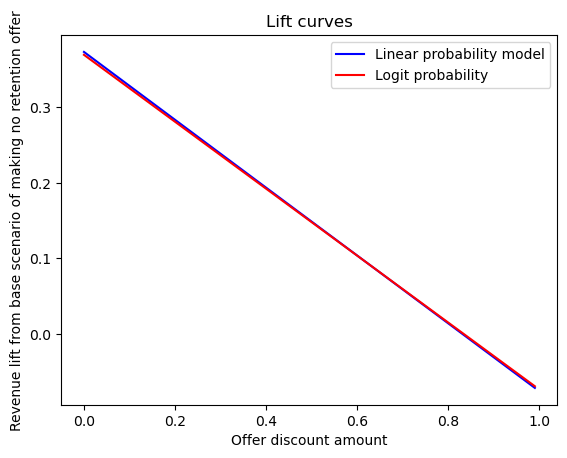

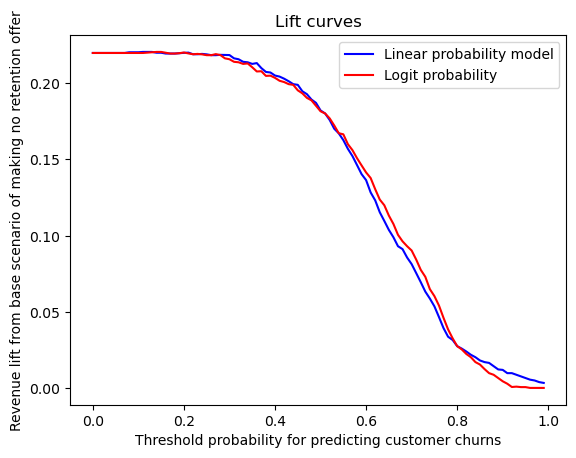

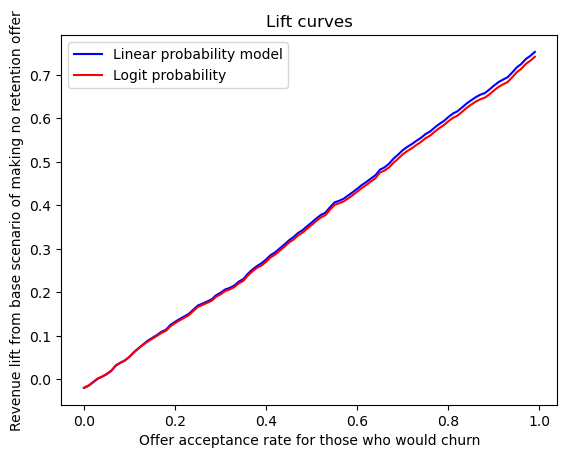

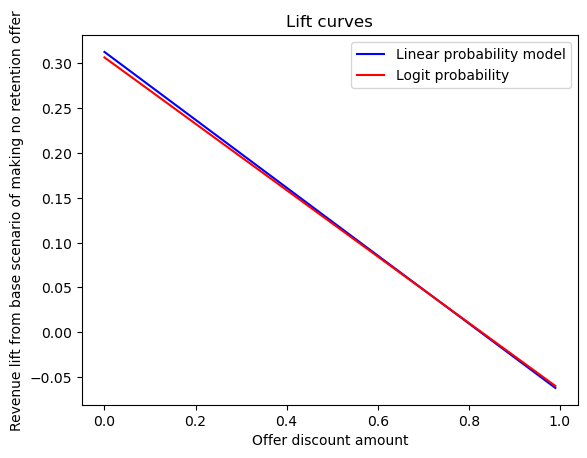

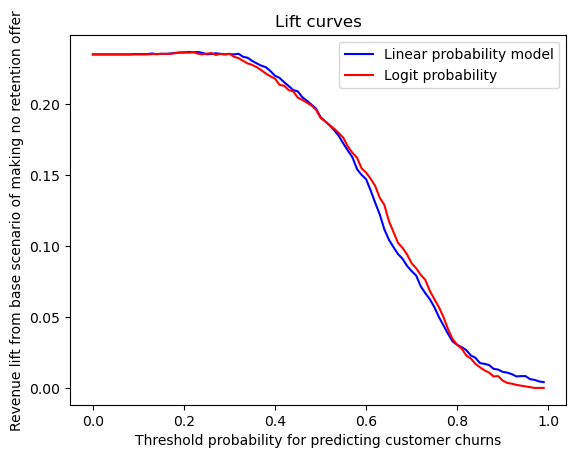

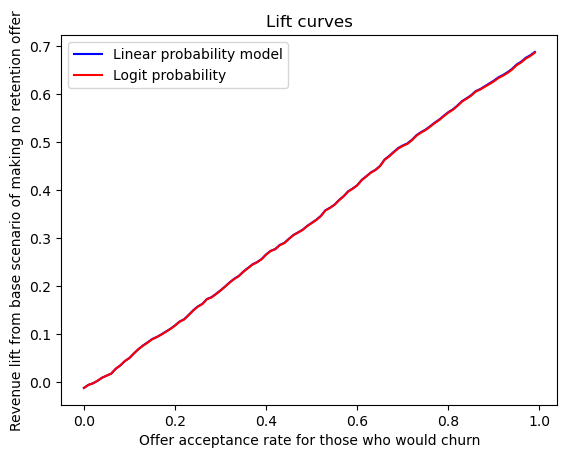

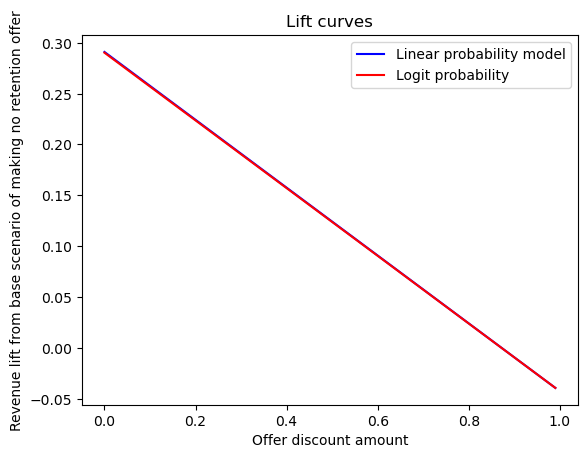

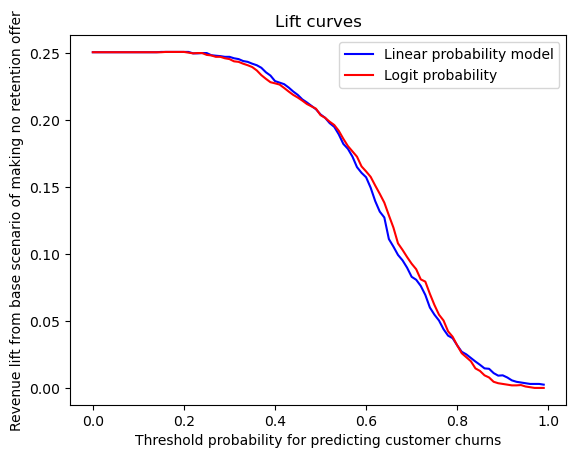

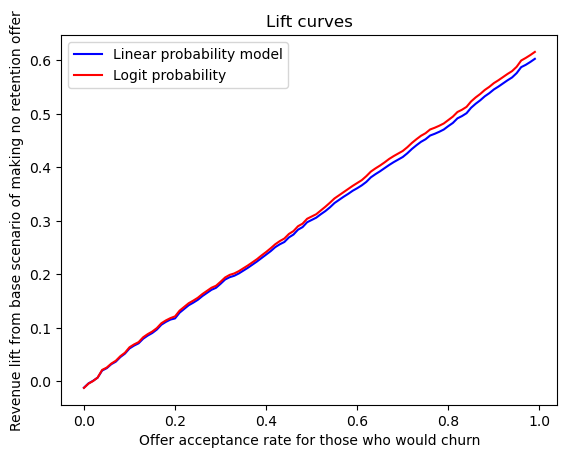

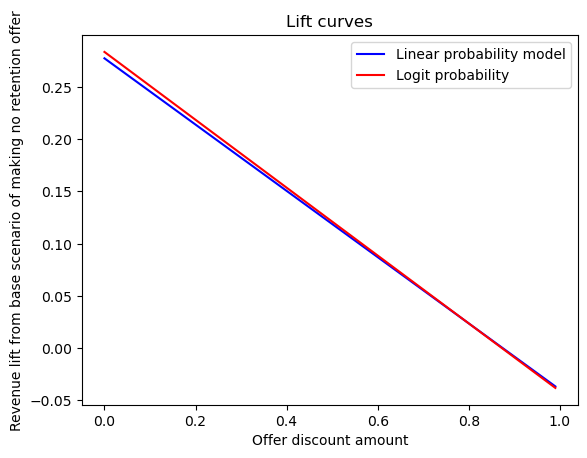

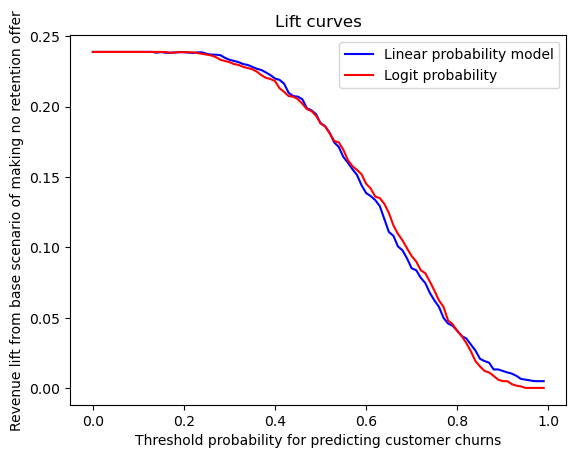

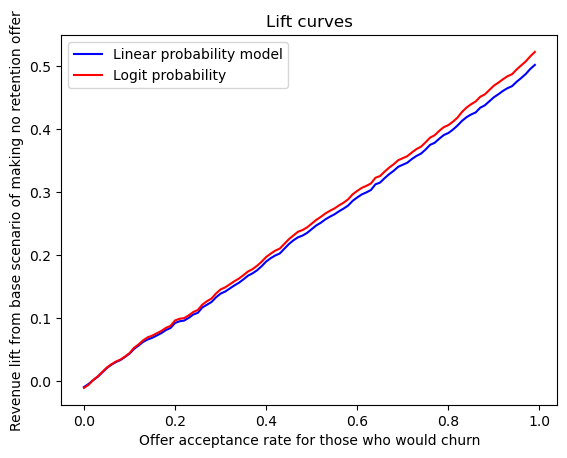

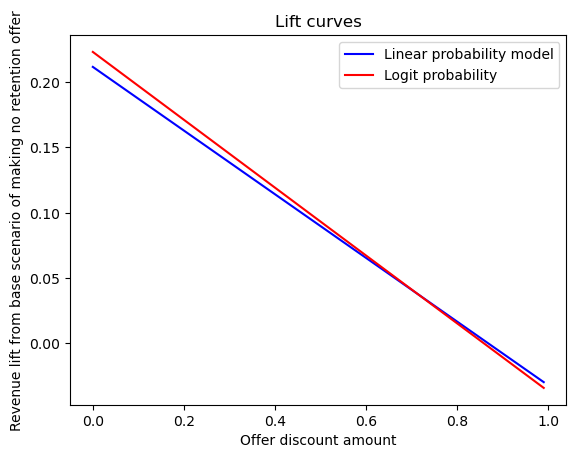

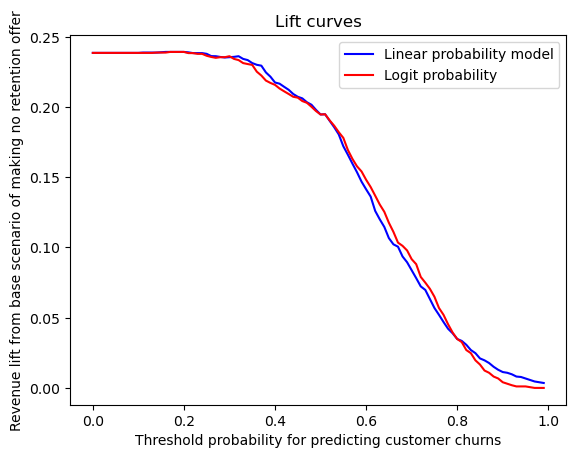

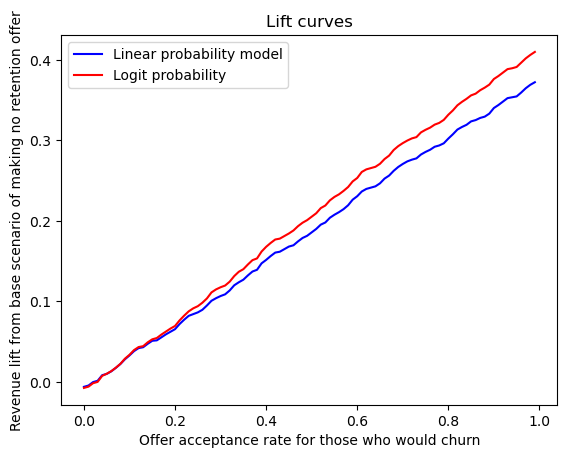

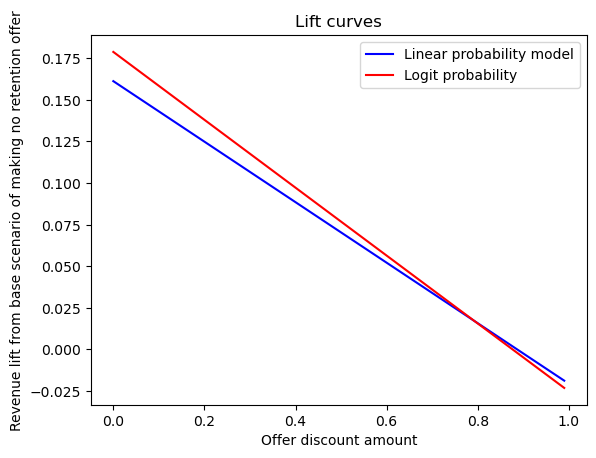

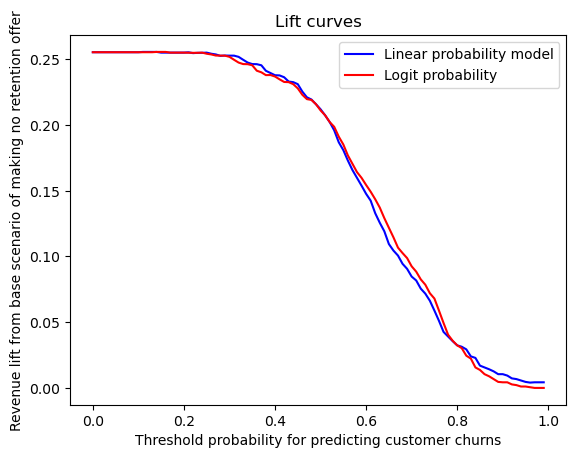

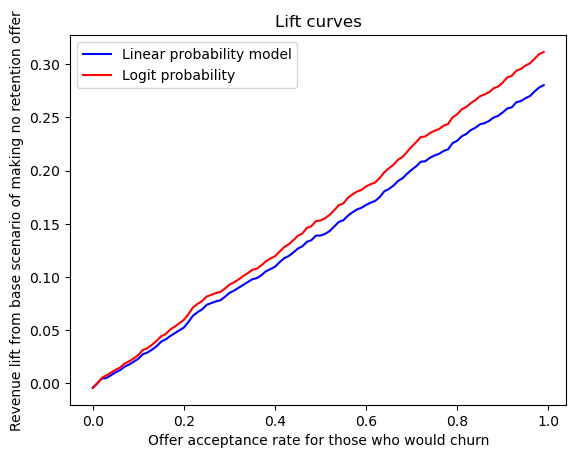

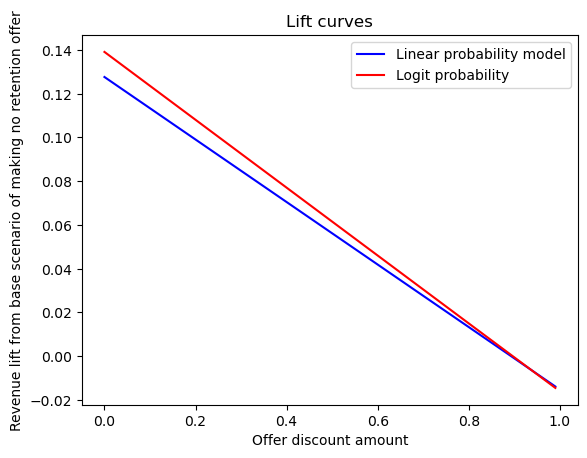

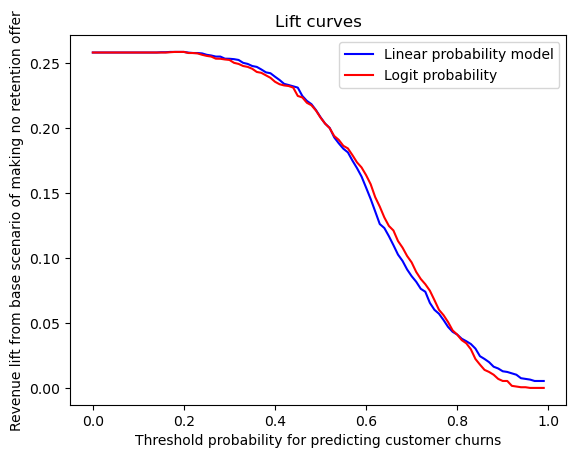

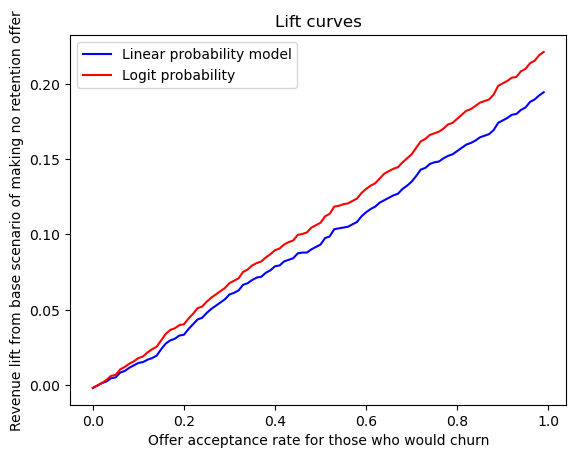

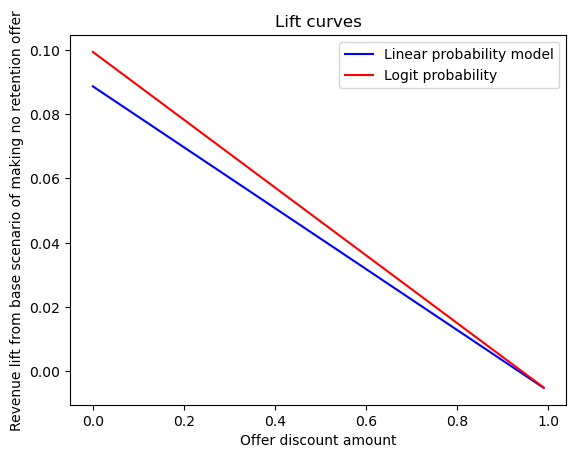

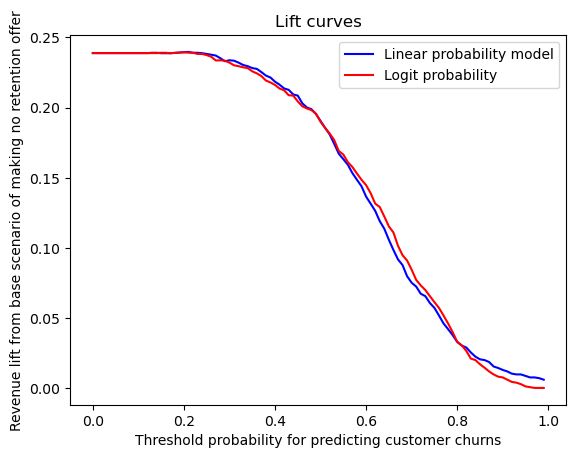

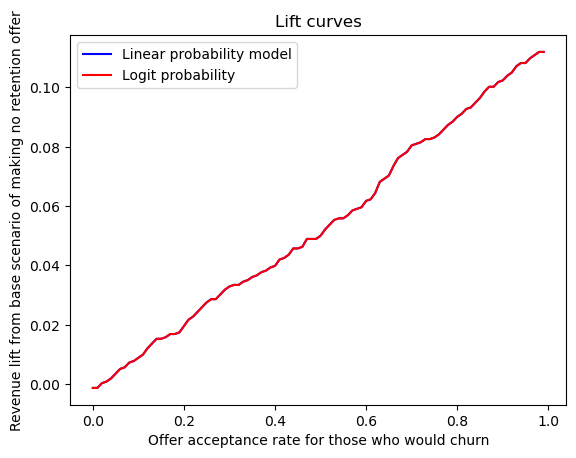

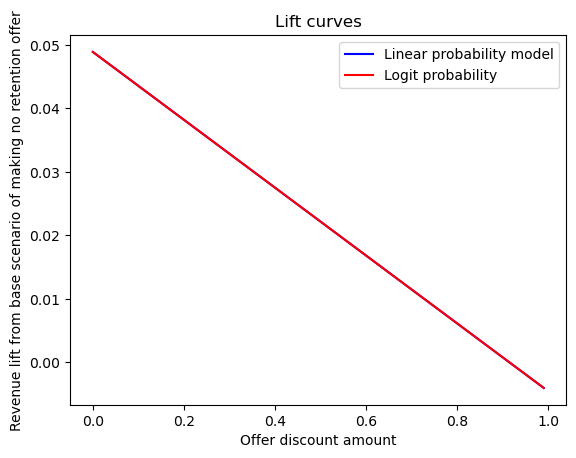

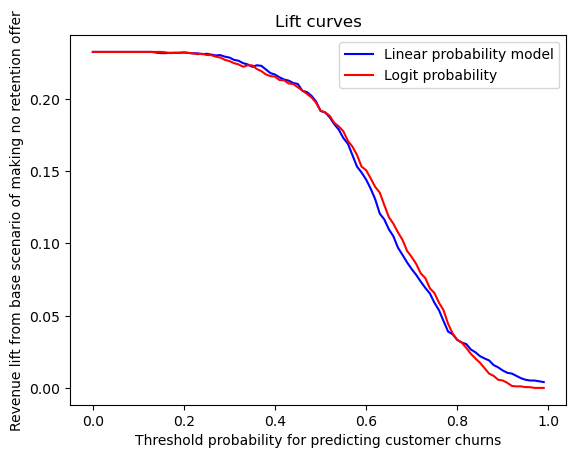

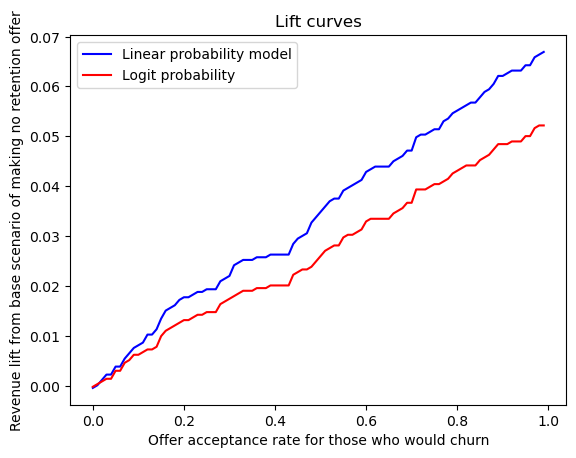

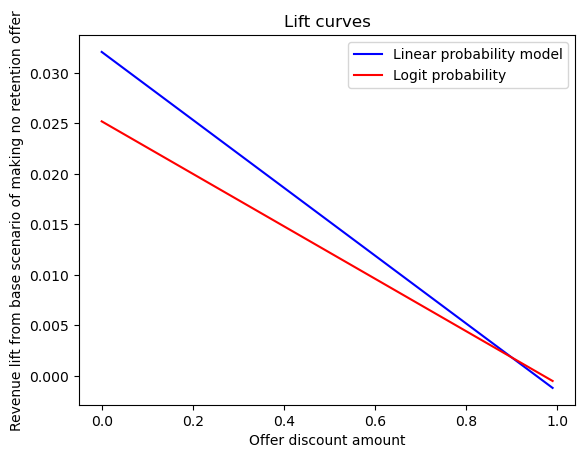

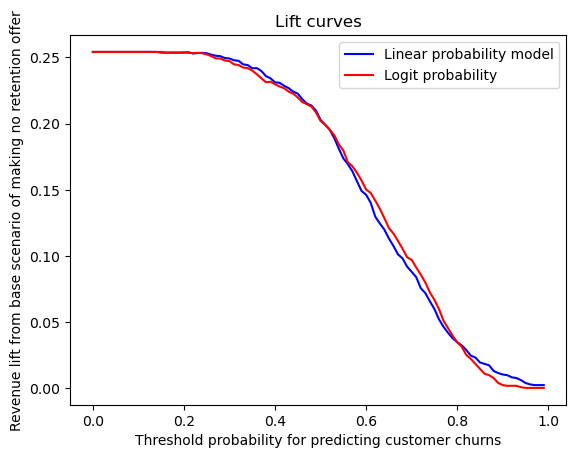

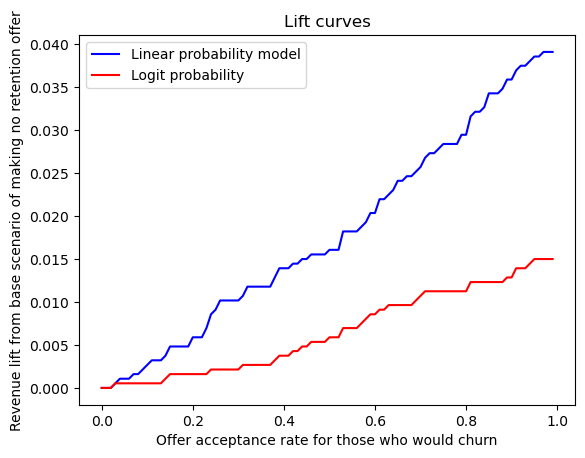

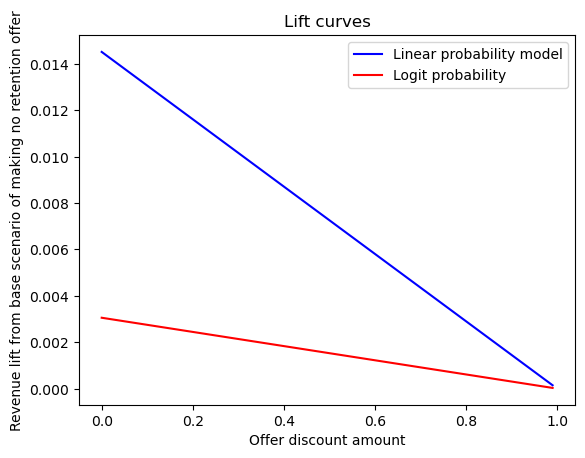

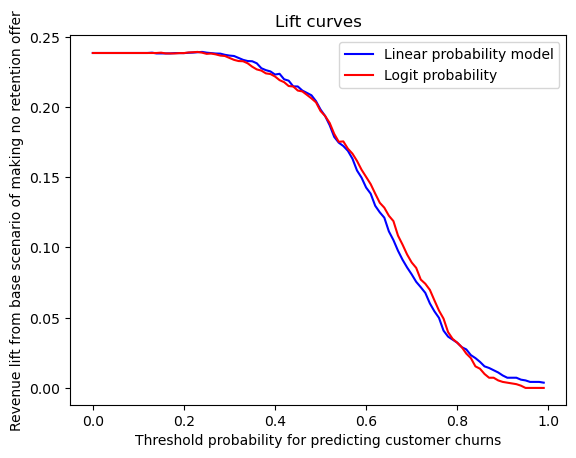

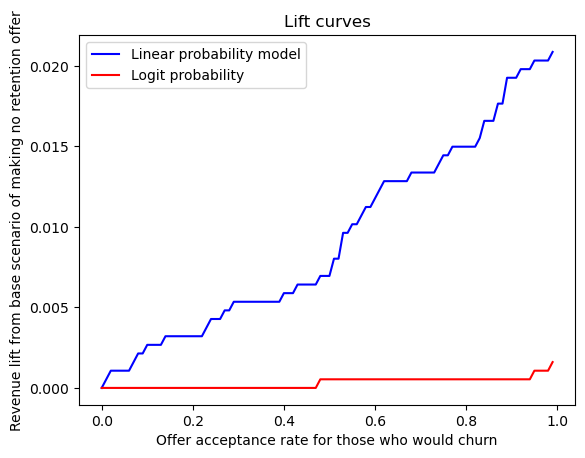

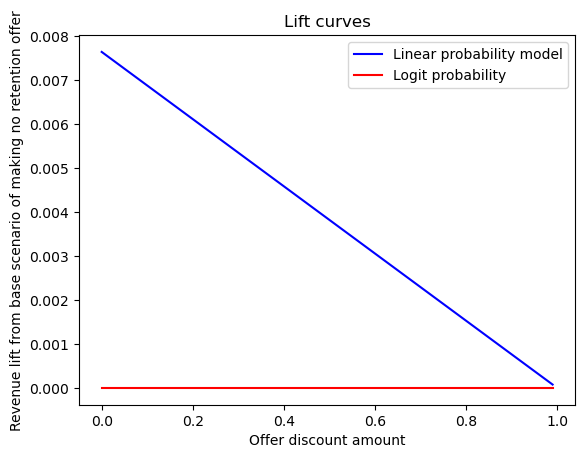

In [97]:
# threshold scenario test
no_offer = pd.DataFrame()
lpm_offer = pd.DataFrame()
logit_offer = pd.DataFrame()

for i in np.arange(0.4, 1, 0.05):
    t1, t2, t3 = impact_test(df_test, 0.1, 0.3, i, 0.3)
    no_offer = pd.concat([no_offer, t1])
    lpm_offer = pd.concat([lpm_offer, t2])
    logit_offer = pd.concat([logit_offer, t3])
    print('THRESHOLD == {}'.format(i))
    print()
    plt.plot()

In [98]:
no_offer

subs revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   
0  1309   13090                0.0                       0.1   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3       0.40              0.3  
0                    0.3       0.45              0.3  
0                    0.3       0.50              0.3  
0                    0.3       0.55              0.3  
0                    0.3       0.60              0.3  
0                    0.3       0.65              0.3  
0                    0.3       0.70              0.3  
0                    0.3       0.75              0.3  
0                    0.3       0.80              0.3  
0                    0.3       0.85              0.3  
0                    0.3       0.90              0.3  
0                    0.3       0.95              0.3

In [99]:
lpm_offer

subs revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1797   16209           0.238273                       0.1   
0  1718   15695           0.199007                       0.1   
0  1690   15589           0.190909                       0.1   
0  1672   15475             0.1822                       0.1   
0  1586   14903           0.138503                       0.1   
0  1520   14486           0.106646                       0.1   
0  1476   14199           0.084721                       0.1   
0  1425   13878           0.060199                       0.1   
0  1373   13520            0.03285                       0.1   
0  1351   13378           0.022002                       0.1   
0  1328   13223            0.01016                       0.1   
0  1319   13160           0.005348                       0.1   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3       0.40              0.3  
0                    0.3       0.45              0.3  
0                    0.3       0.50              0.3  
0                    0.3       0.55              0.3  
0                    0.3       0.60              0.3  
0                    0.3       0.65              0.3  
0                    0.3       0.70              0.3  
0                    0.3       0.75              0.3  
0                    0.3       0.80              0.3  
0                    0.3       0.85              0.3  
0                    0.3       0.90              0.3  
0                    0.3       0.95              0.3

In [100]:
logit_offer

subs revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1792   16183           0.236287                       0.1   
0  1710   15648           0.195416                       0.1   
0  1689   15582           0.190374                       0.1   
0  1680   15525            0.18602                       0.1   
0  1601   14990           0.145149                       0.1   
0  1543   14629           0.117571                       0.1   
0  1491   14301           0.092513                       0.1   
0  1439   13976           0.067685                       0.1   
0  1373   13520            0.03285                       0.1   
0  1342   13318           0.017418                       0.1   
0  1313   13118           0.002139                       0.1   
0  1309   13090                0.0                       0.1   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3       0.40              0.3  
0                    0.3       0.45              0.3  
0                    0.3       0.50              0.3  
0                    0.3       0.55              0.3  
0                    0.3       0.60              0.3  
0                    0.3       0.65              0.3  
0                    0.3       0.70              0.3  
0                    0.3       0.75              0.3  
0                    0.3       0.80              0.3  
0                    0.3       0.85              0.3  
0                    0.3       0.90              0.3  
0                    0.3       0.95              0.3

<AxesSubplot:xlabel='threshold'>

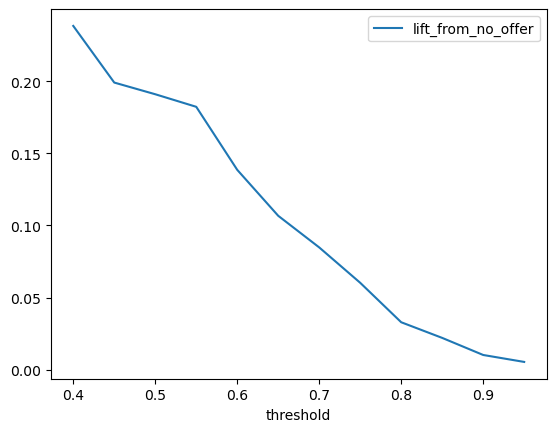

In [103]:
lpm_offer.plot(x='threshold', y='lift_from_no_offer')

<AxesSubplot:xlabel='threshold'>

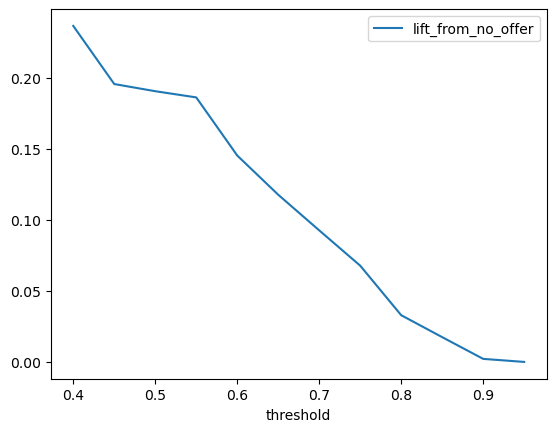

In [104]:
logit_offer.plot(x='threshold', y='lift_from_no_offer')

Non Churner Acceptance Rate == 0.0

Non Churner Acceptance Rate == 0.05

Non Churner Acceptance Rate == 0.1

Non Churner Acceptance Rate == 0.15000000000000002

Non Churner Acceptance Rate == 0.2

Non Churner Acceptance Rate == 0.25



/var/folders/42/jjtp5rtx10ddt53ggkm3x1280000gn/T/ipykernel_67315/2321014217.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Non Churner Acceptance Rate == 0.30000000000000004

Non Churner Acceptance Rate == 0.35000000000000003

Non Churner Acceptance Rate == 0.4

Non Churner Acceptance Rate == 0.45

Non Churner Acceptance Rate == 0.5

Non Churner Acceptance Rate == 0.55

Non Churner Acceptance Rate == 0.6000000000000001

Non Churner Acceptance Rate == 0.65

Non Churner Acceptance Rate == 0.7000000000000001

Non Churner Acceptance Rate == 0.75

Non Churner Acceptance Rate == 0.8

Non Churner Acceptance Rate == 0.8500000000000001

Non Churner Acceptance Rate == 0.9

Non Churner Acceptance Rate == 0.9500000000000001



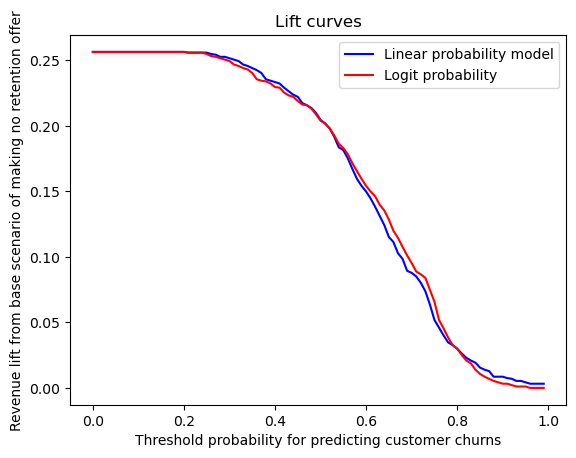

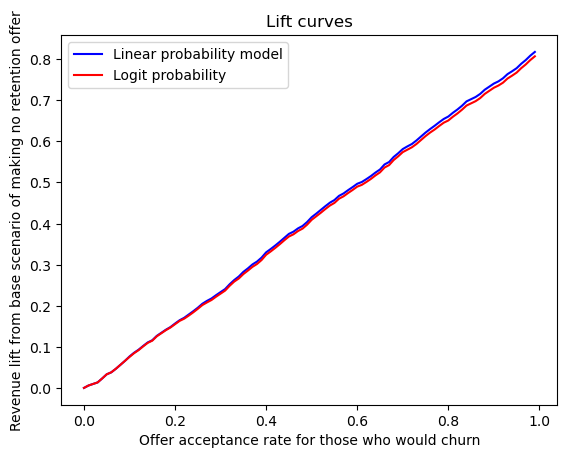

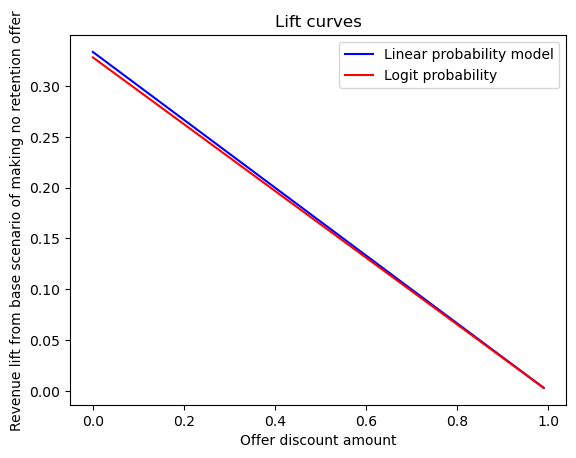

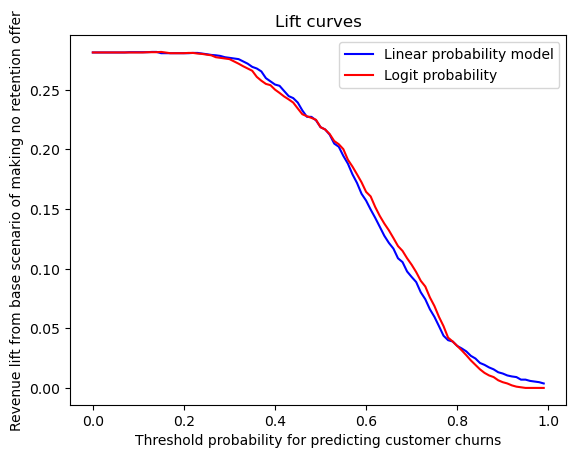

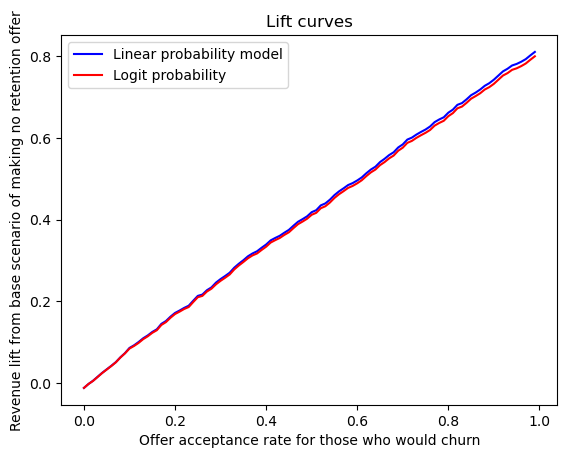

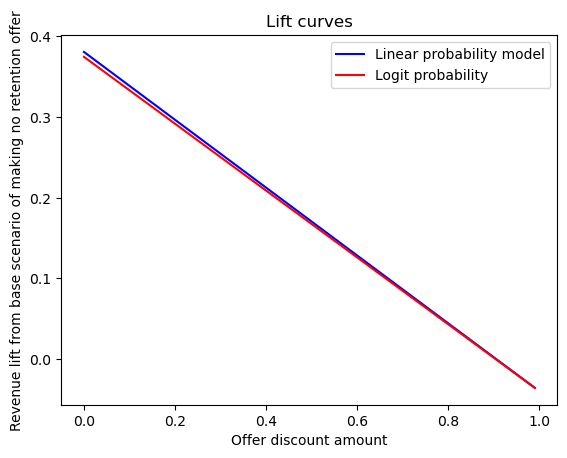

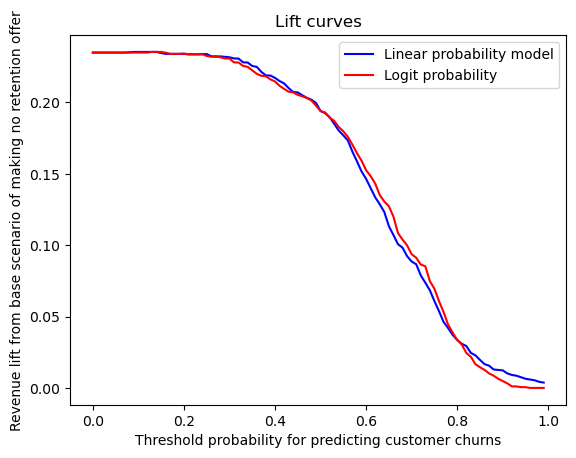

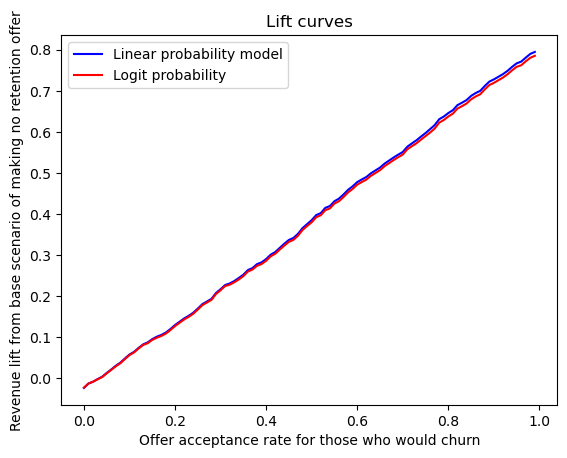

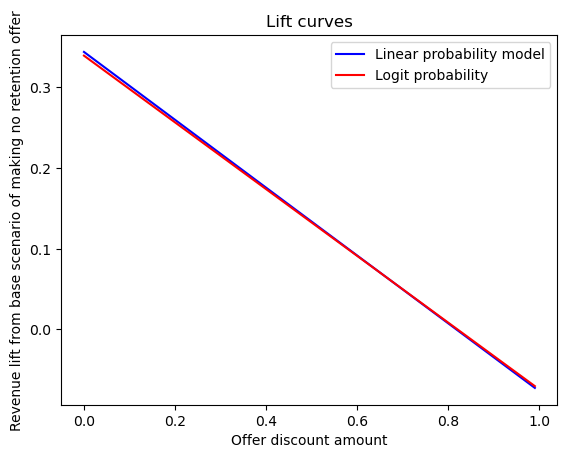

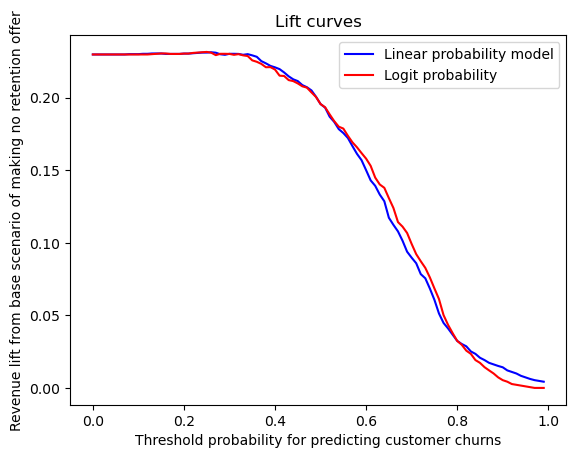

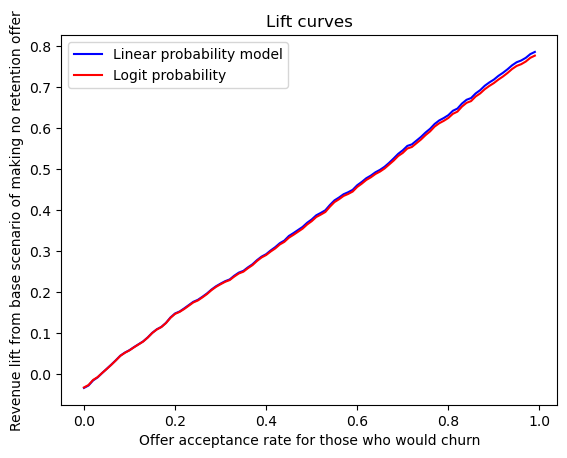

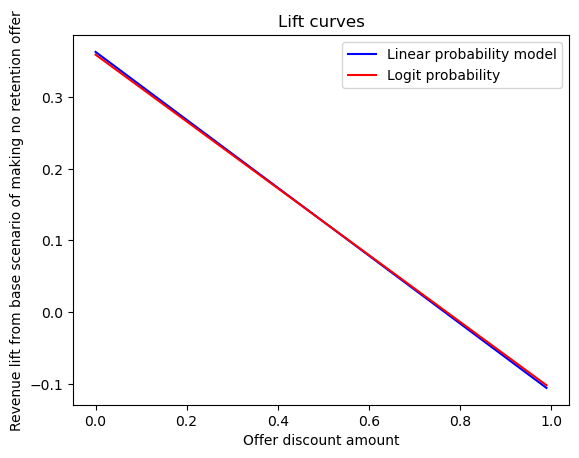

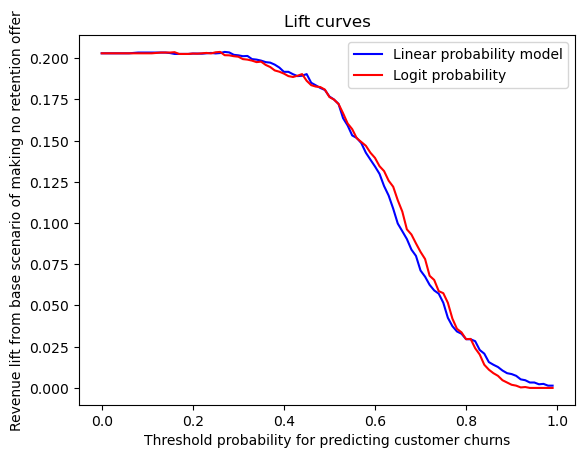

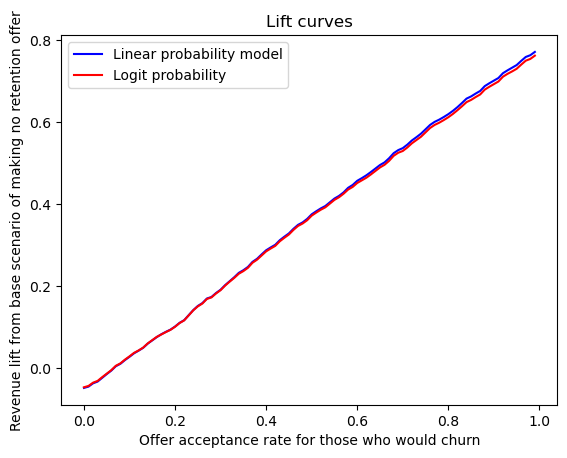

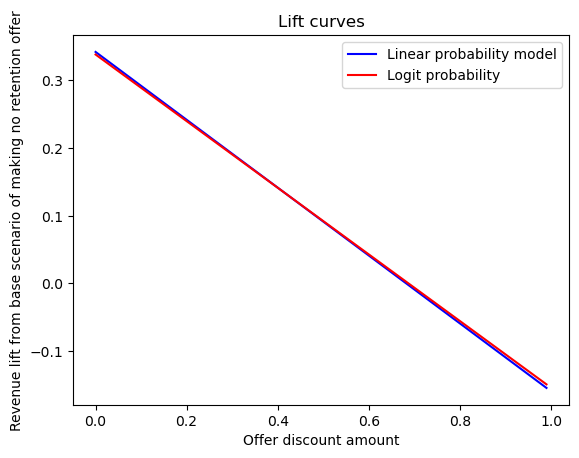

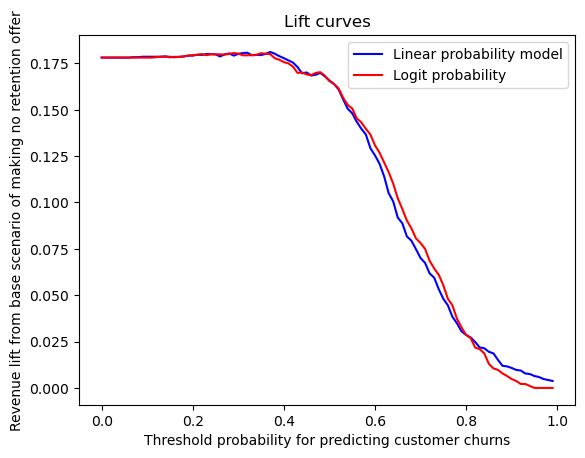

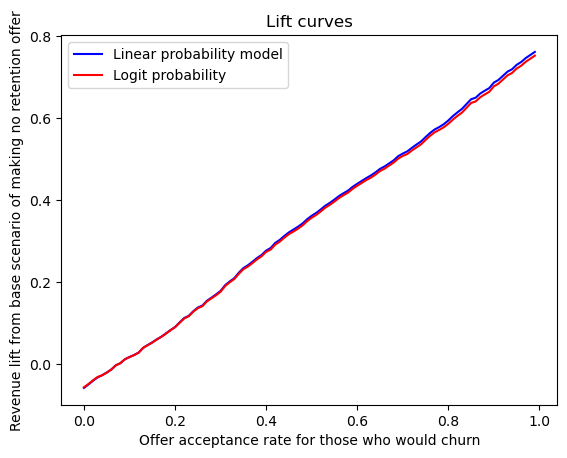

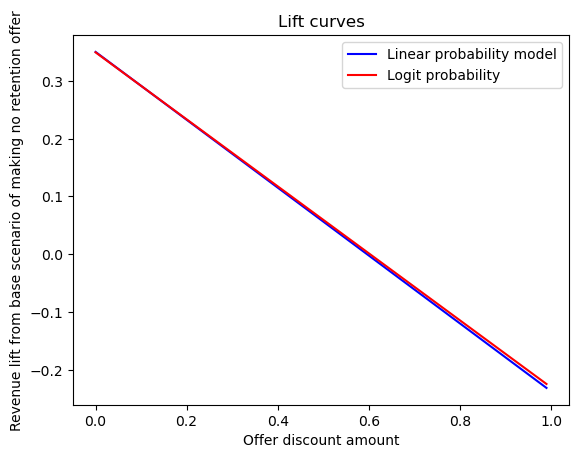

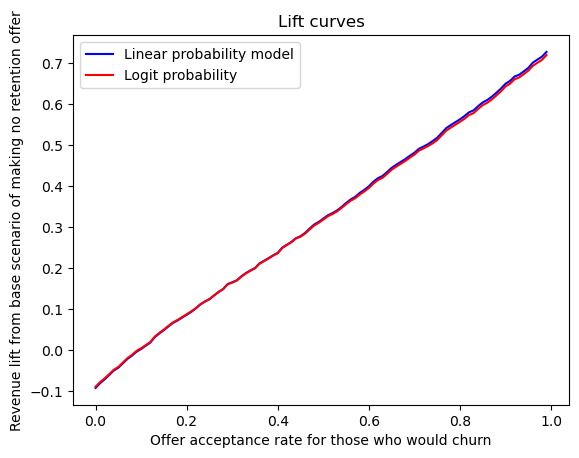

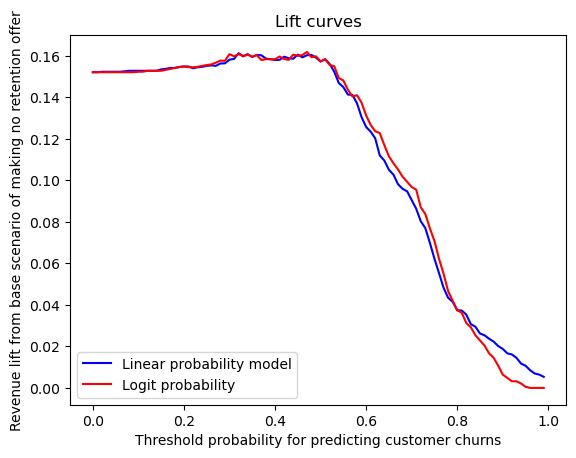

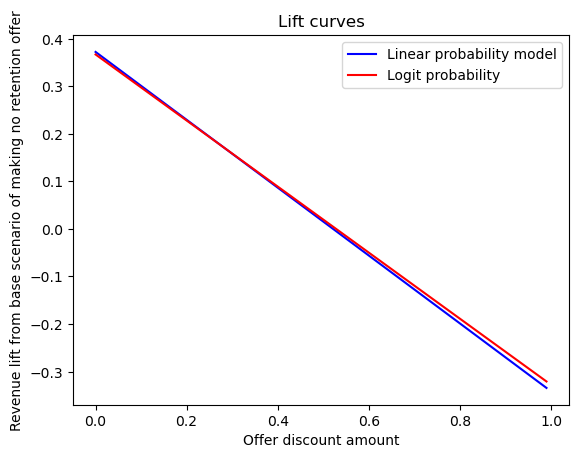

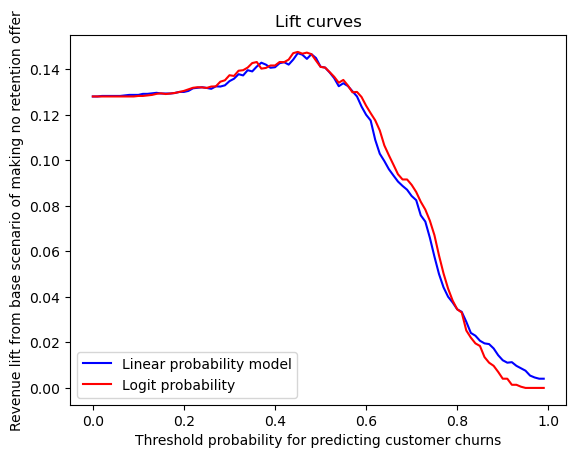

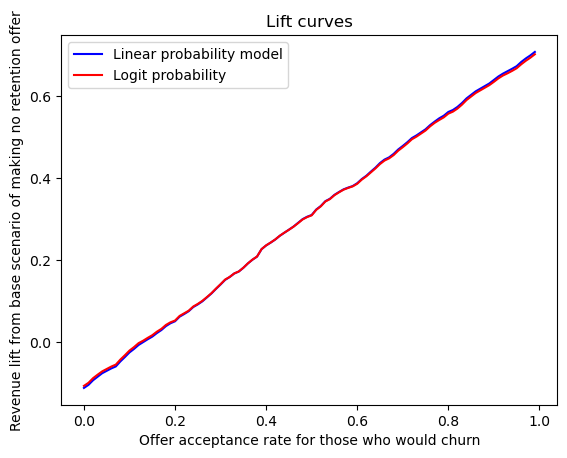

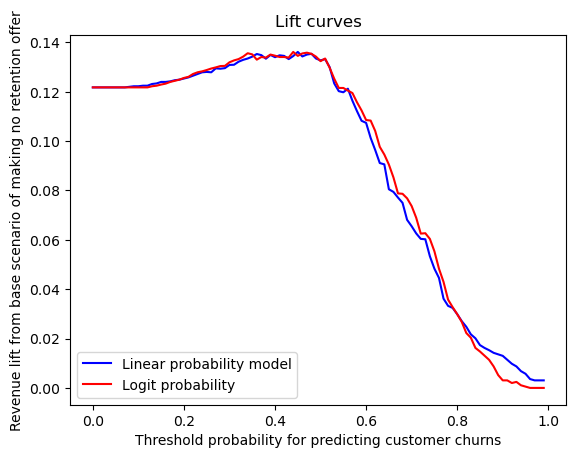

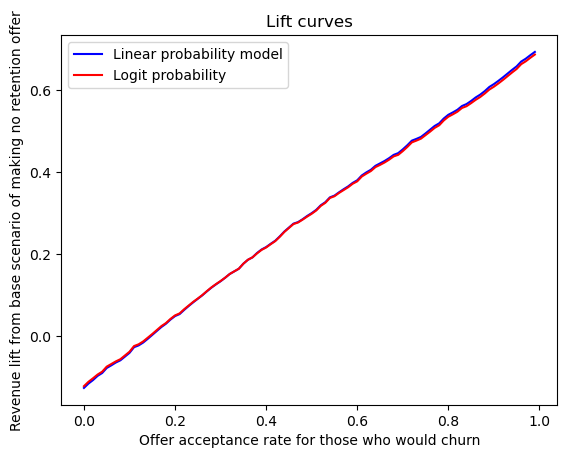

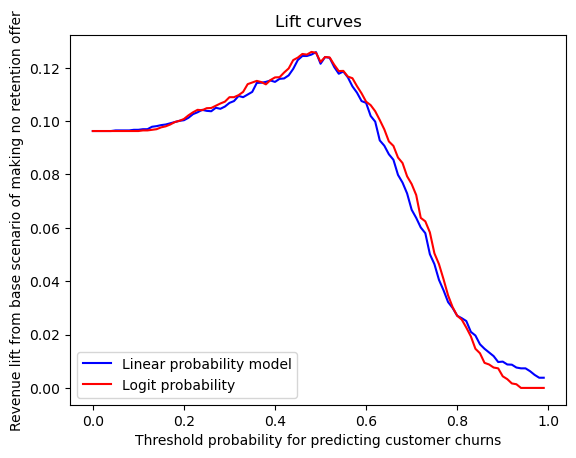

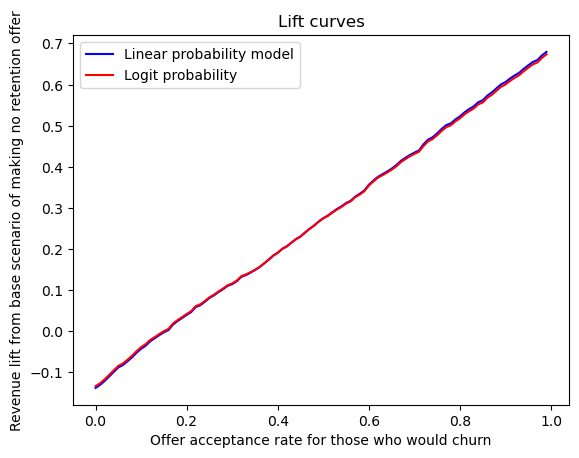

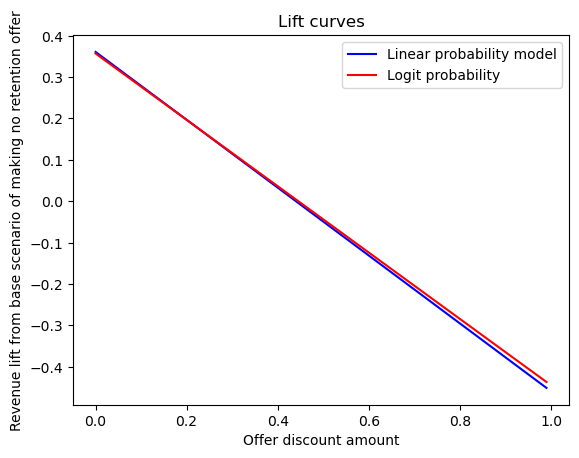

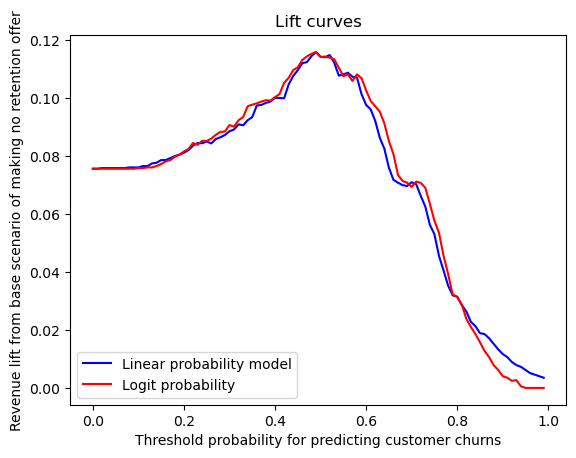

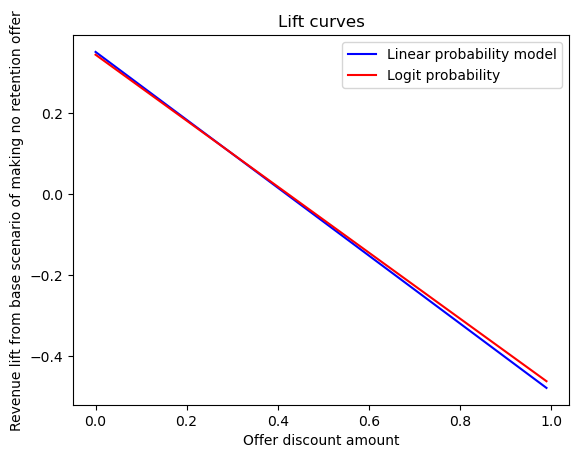

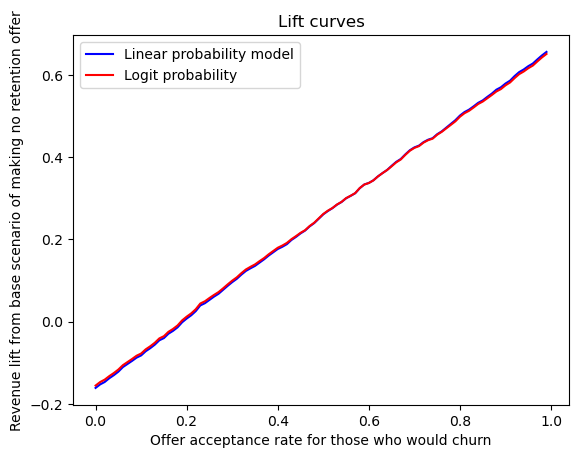

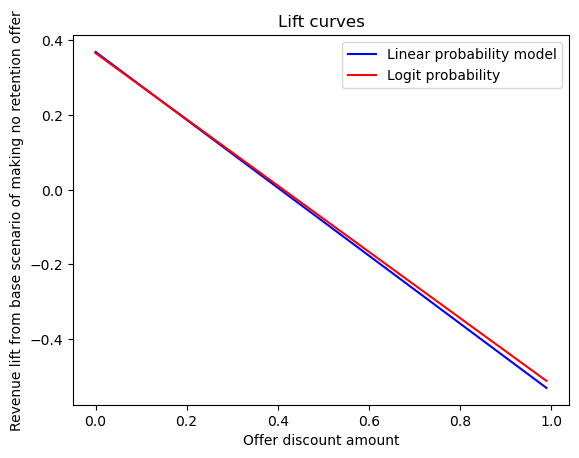

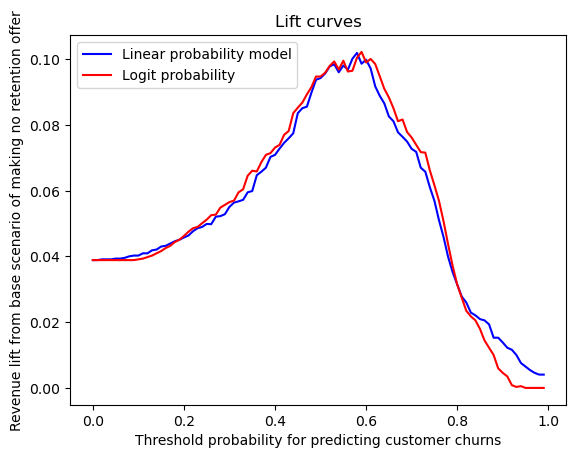

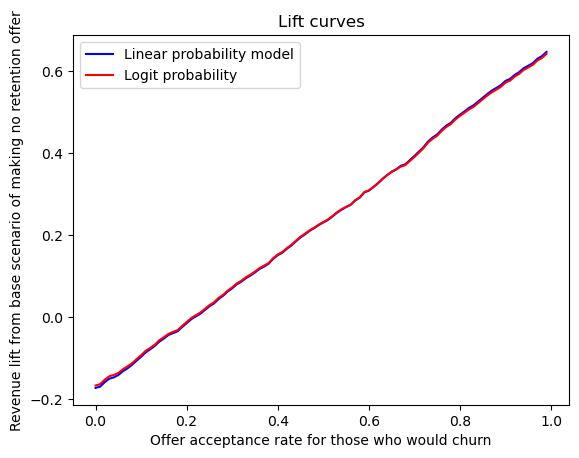

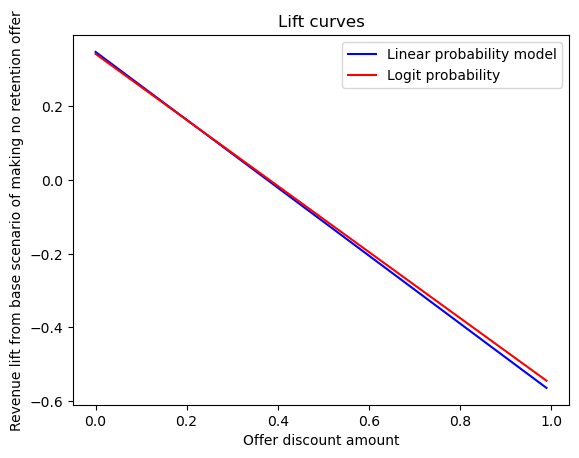

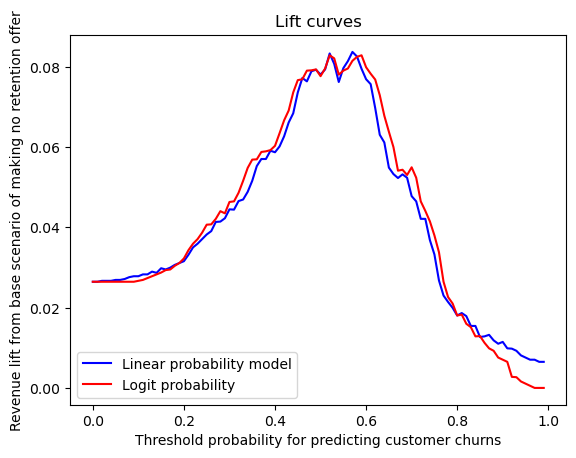

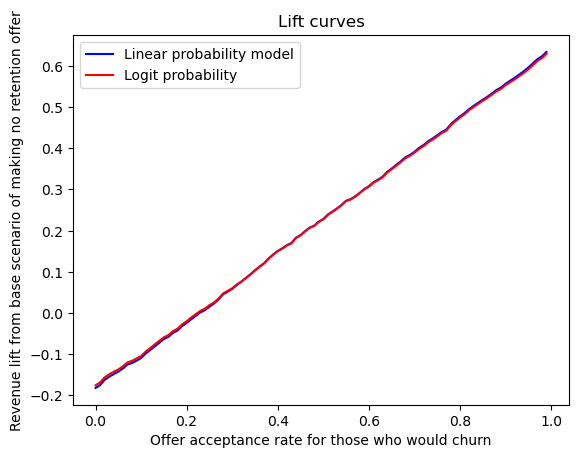

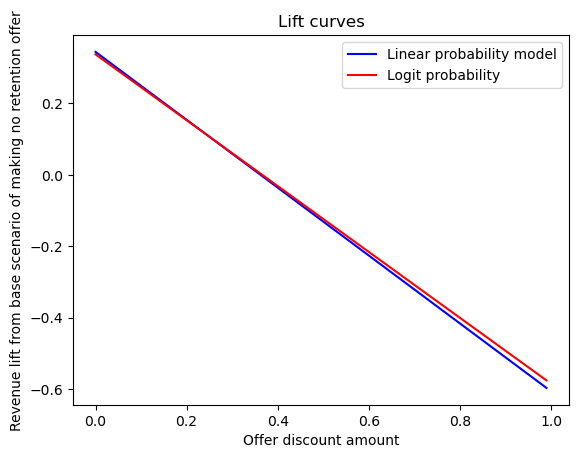

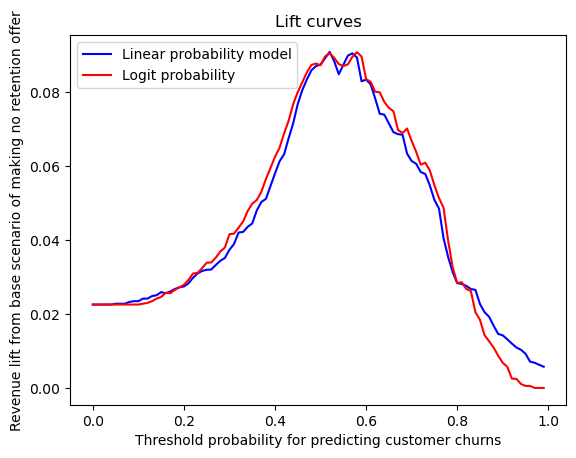

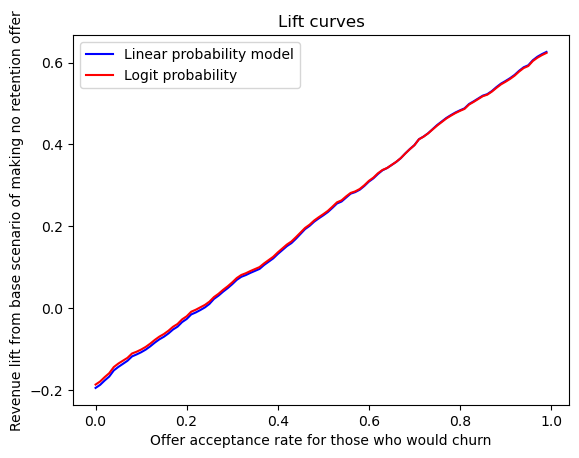

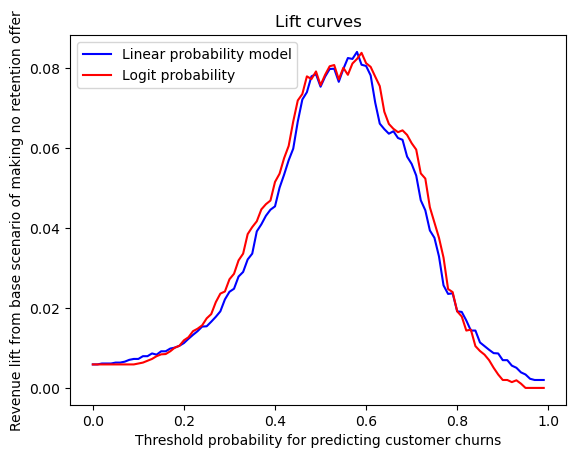

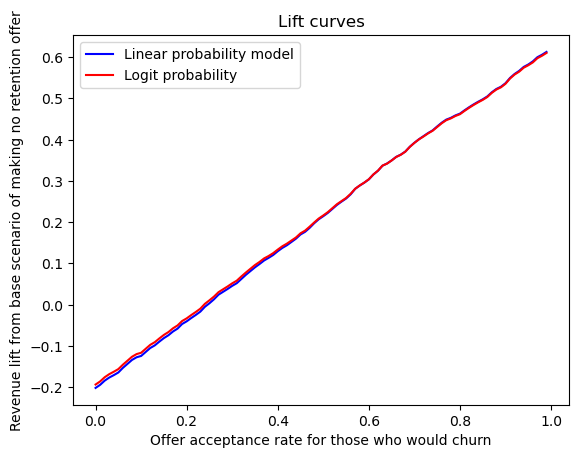

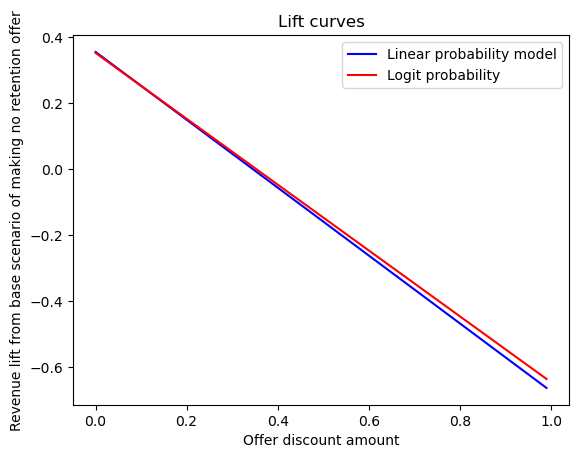

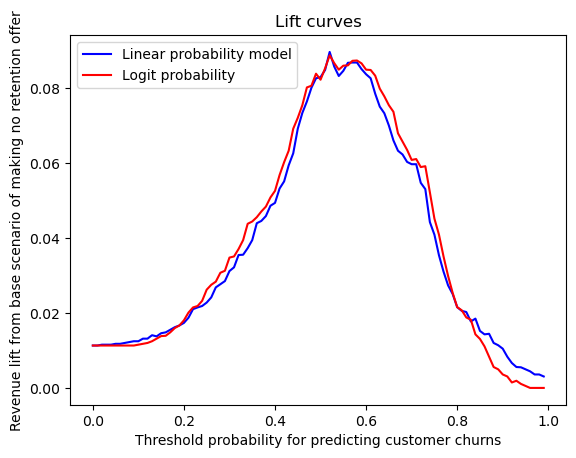

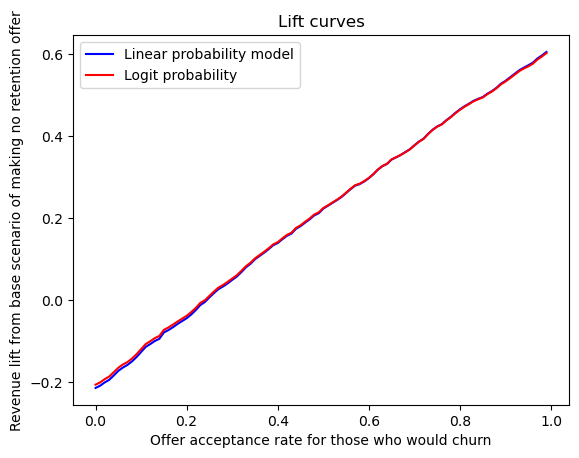

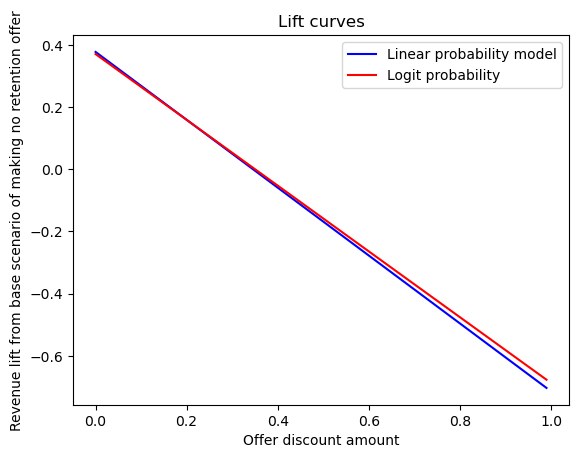

In [105]:
# nonchurner acceptance rate scenario test
no_offer = pd.DataFrame()
lpm_offer = pd.DataFrame()
logit_offer = pd.DataFrame()

for i in np.arange(0, 1, 0.05):
    t1, t2, t3 = impact_test(df_test, i, 0.3, 0.4, 0.3)
    no_offer = pd.concat([no_offer, t1])
    lpm_offer = pd.concat([lpm_offer, t2])
    logit_offer = pd.concat([logit_offer, t3])
    print('Non Churner Acceptance Rate == {}'.format(i))
    print()
    plt.plot()

In [89]:
no_offer

subs revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1309   13090                0.0                      0.00   
0  1309   13090                0.0                      0.05   
0  1309   13090                0.0                      0.10   
0  1309   13090                0.0                      0.15   
0  1309   13090                0.0                      0.20   
0  1309   13090                0.0                      0.25   
0  1309   13090                0.0                      0.30   
0  1309   13090                0.0                      0.35   
0  1309   13090                0.0                      0.40   
0  1309   13090                0.0                      0.45   
0  1309   13090                0.0                      0.50   
0  1309   13090                0.0                      0.55   
0  1309   13090                0.0                      0.60   
0  1309   13090                0.0                      0.65   
0  1309   13090                0.0                      0.70   
0  1309   13090                0.0                      0.75   
0  1309   13090                0.0                      0.80   
0  1309   13090                0.0                      0.85   
0  1309   13090                0.0                      0.90   
0  1309   13090                0.0                      0.95   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3  
0                    0.3        0.6              0.3

In [106]:
lpm_offer

subs revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1745   16142           0.233155                      0.00   
0  1807   16420           0.254393                      0.05   
0  1758   15933           0.217189                      0.10   
0  1784   15980           0.220779                      0.15   
0  1757   15599           0.191673                      0.20   
0  1752   15417           0.177769                      0.25   
0  1767   15366           0.173873                      0.30   
0  1807   15457           0.180825                      0.35   
0  1790   15257           0.165546                      0.40   
0  1796   15158           0.157983                      0.45   
0  1781   14933           0.140794                      0.50   
0  1796   14843           0.133919                      0.55   
0  1781   14591           0.114668                      0.60   
0  1769   14399                0.1                      0.65   
0  1791   14346           0.095951                      0.70   
0  1763   14018           0.070894                      0.75   
0  1759   13858           0.058671                      0.80   
0  1783   13849           0.057983                      0.85   
0  1772   13685           0.045455                      0.90   
0  1802   13736           0.049351                      0.95   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3

In [107]:
logit_offer

subs revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1738   16093           0.229412                      0.00   
0  1799   16364           0.250115                      0.05   
0  1752   15900           0.214668                      0.10   
0  1779   15960           0.219251                      0.15   
0  1752   15585           0.190604                      0.20   
0  1745   15389            0.17563                      0.25   
0  1766   15386           0.175401                      0.30   
0  1800   15453           0.180519                      0.35   
0  1783   15247           0.164782                      0.40   
0  1789   15163           0.158365                      0.45   
0  1773   14943           0.141558                      0.50   
0  1789   14851            0.13453                      0.55   
0  1776   14613           0.116348                      0.60   
0  1760   14402           0.100229                      0.65   
0  1787   14393           0.099542                      0.70   
0  1756   14047           0.073109                      0.75   
0  1750   13879           0.060275                      0.80   
0  1776   13908            0.06249                      0.85   
0  1768   13765           0.051566                      0.90   
0  1793   13778           0.052559                      0.95   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3  
0                    0.3        0.4              0.3

<AxesSubplot:xlabel='acceptance_rate_nonchurn'>

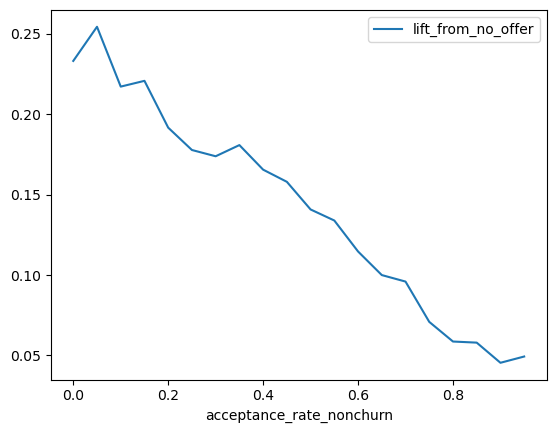

In [108]:
lpm_offer[['lift_from_no_offer', 'acceptance_rate_nonchurn']].plot(x='acceptance_rate_nonchurn', y='lift_from_no_offer')

<AxesSubplot:xlabel='acceptance_rate_nonchurn'>

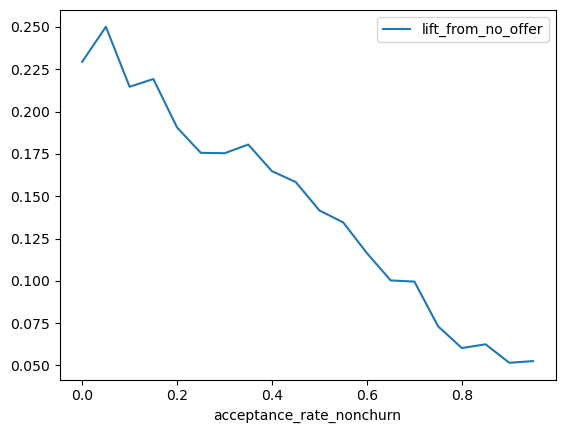

In [109]:
logit_offer[['lift_from_no_offer', 'acceptance_rate_nonchurn']].plot(x='acceptance_rate_nonchurn', y='lift_from_no_offer')

Non Churner Acceptance Rate == 0.05

Non Churner Acceptance Rate == 0.1

Non Churner Acceptance Rate == 0.15000000000000002

Non Churner Acceptance Rate == 0.2

Non Churner Acceptance Rate == 0.25

Non Churner Acceptance Rate == 0.3



/var/folders/42/jjtp5rtx10ddt53ggkm3x1280000gn/T/ipykernel_67315/2321014217.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Non Churner Acceptance Rate == 0.35000000000000003

Non Churner Acceptance Rate == 0.4

Non Churner Acceptance Rate == 0.45



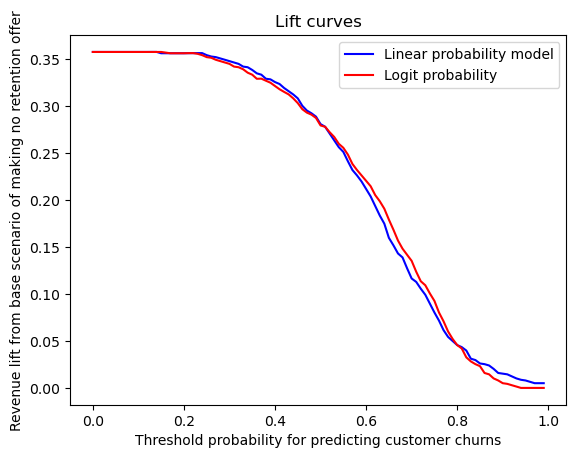

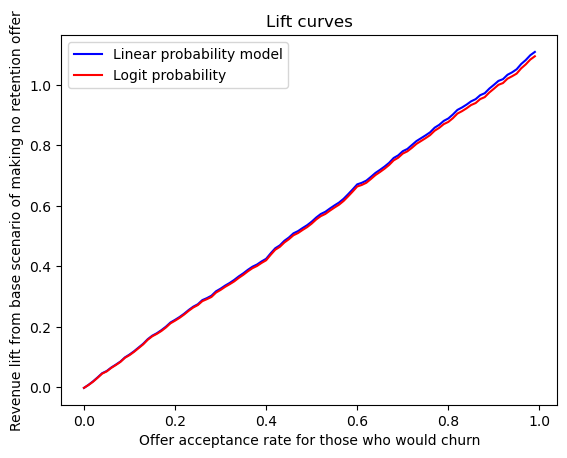

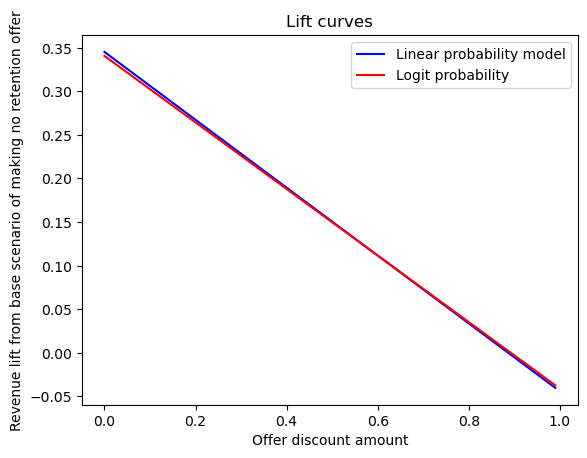

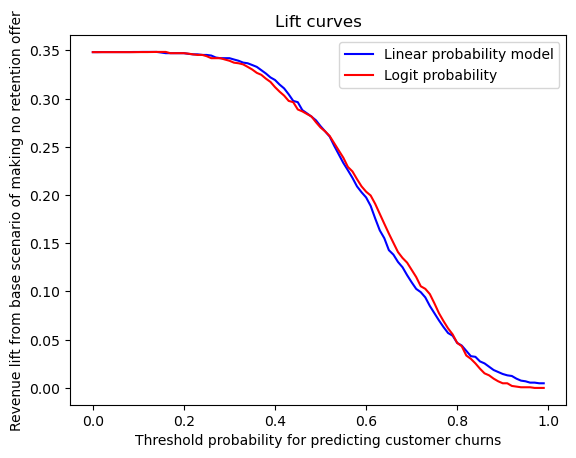

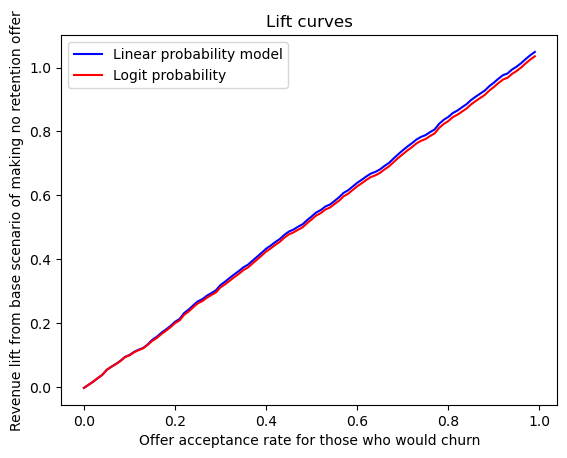

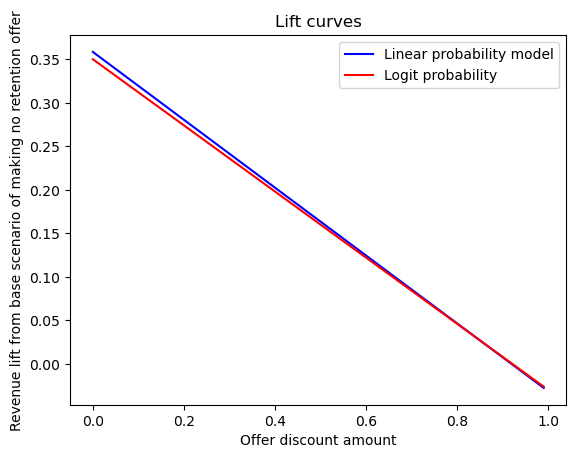

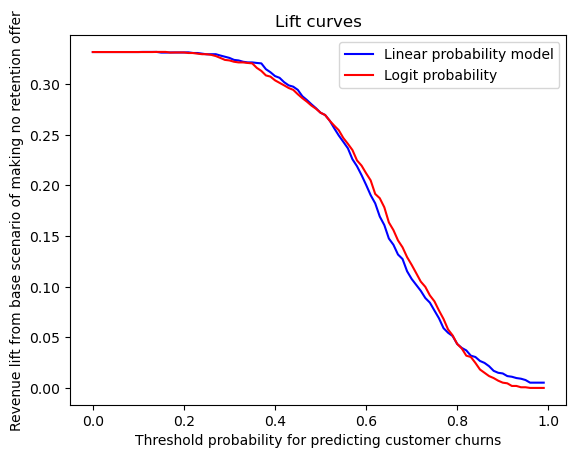

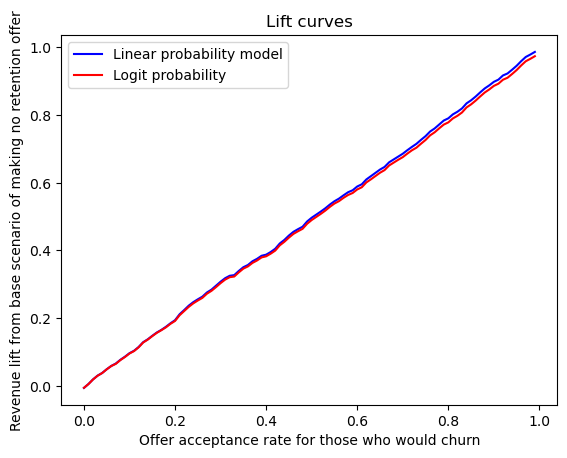

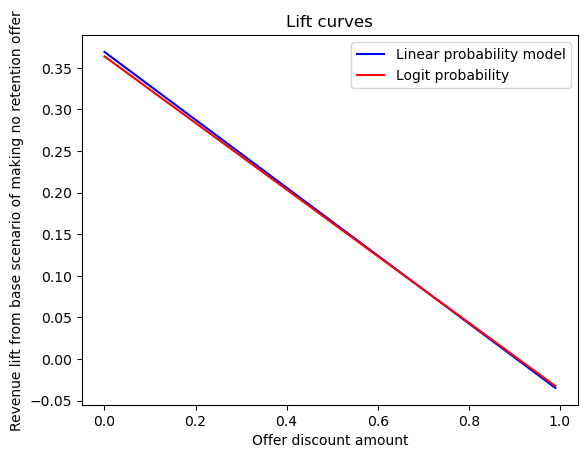

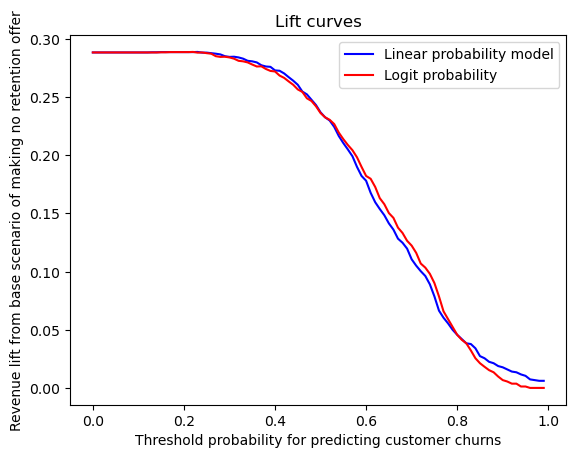

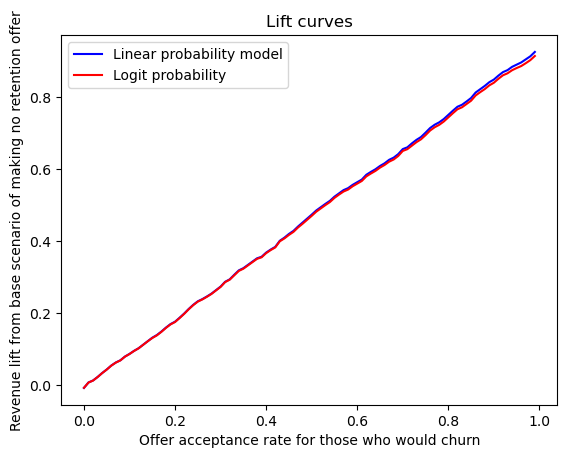

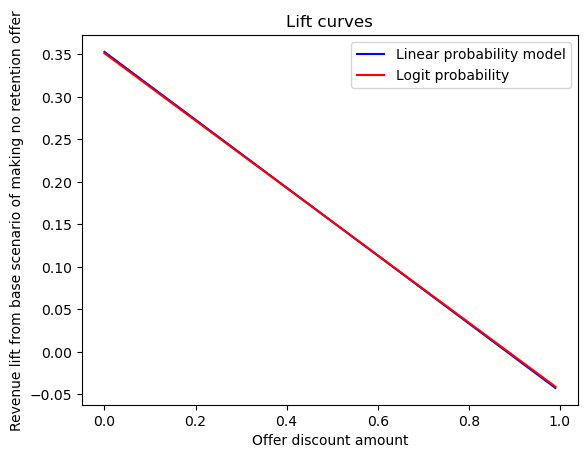

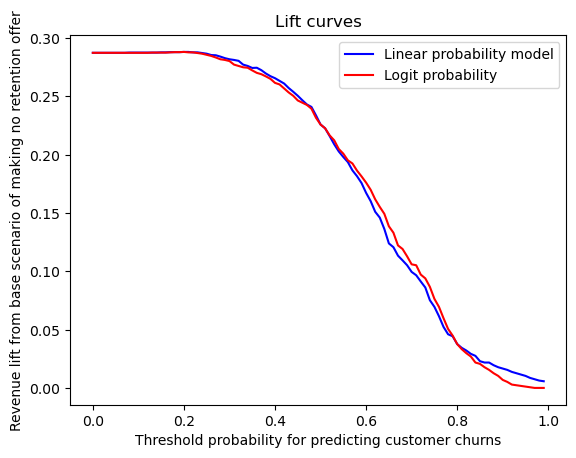

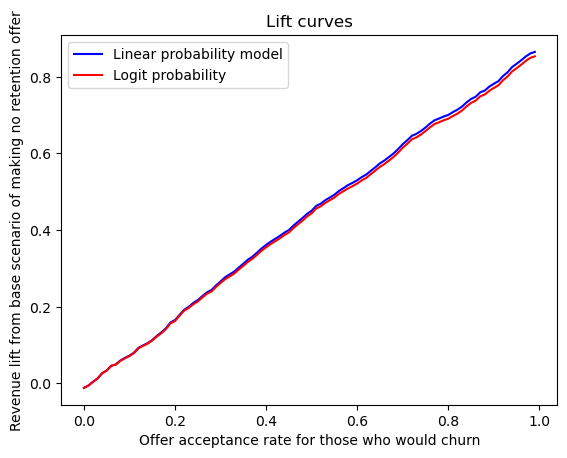

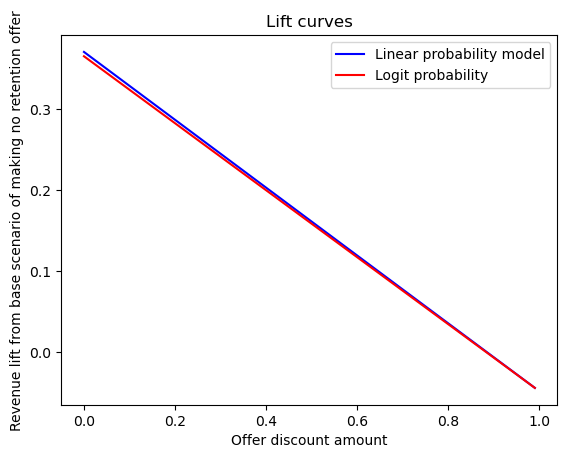

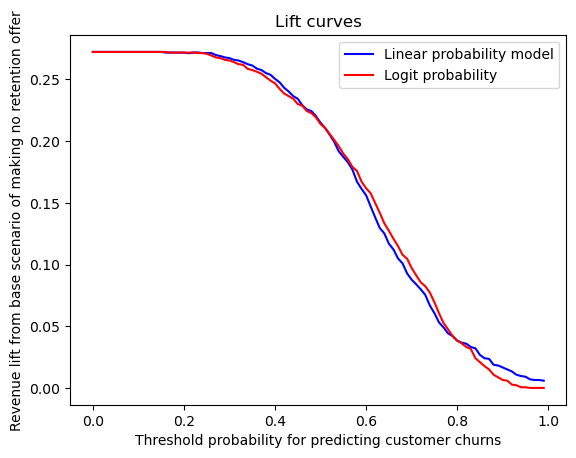

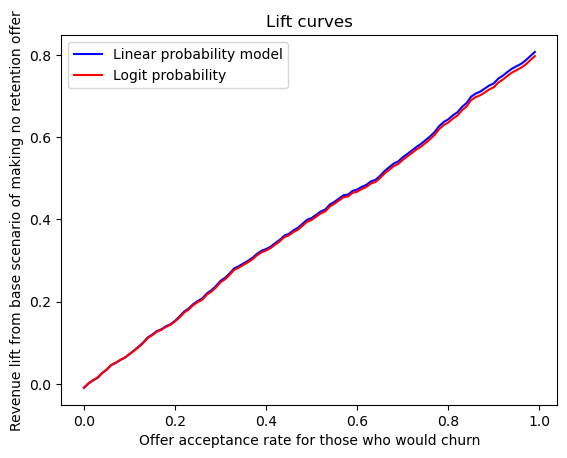

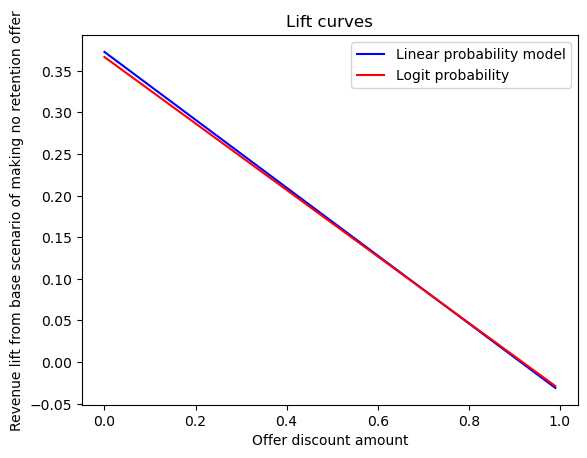

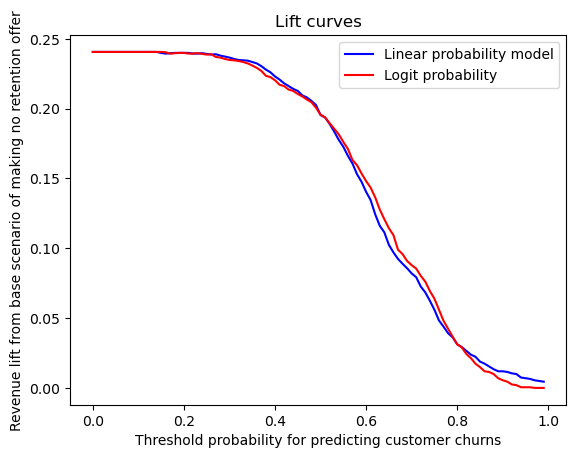

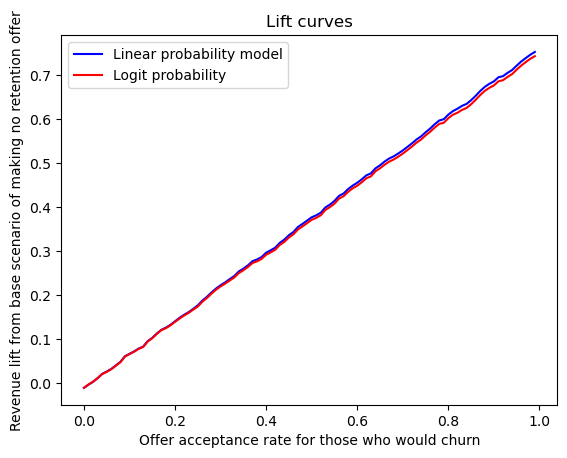

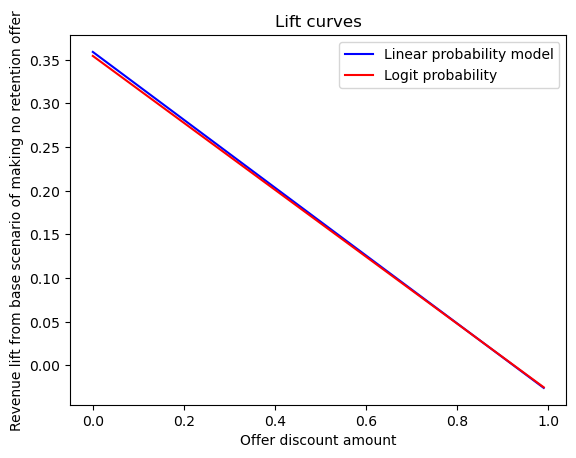

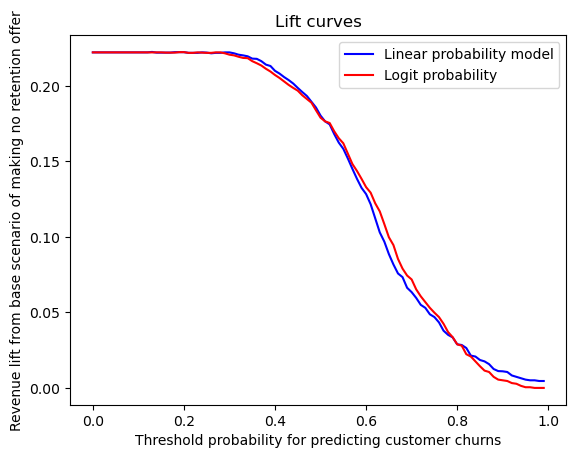

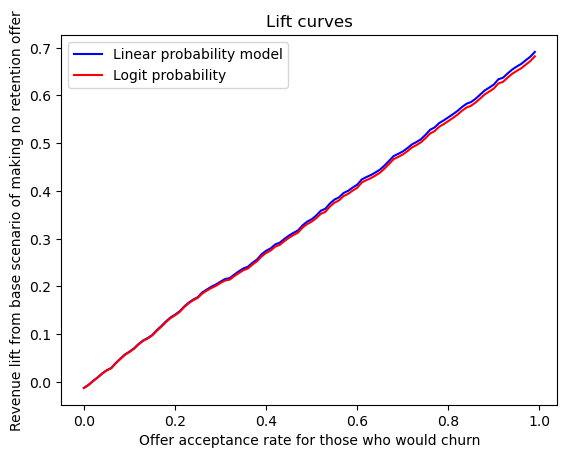

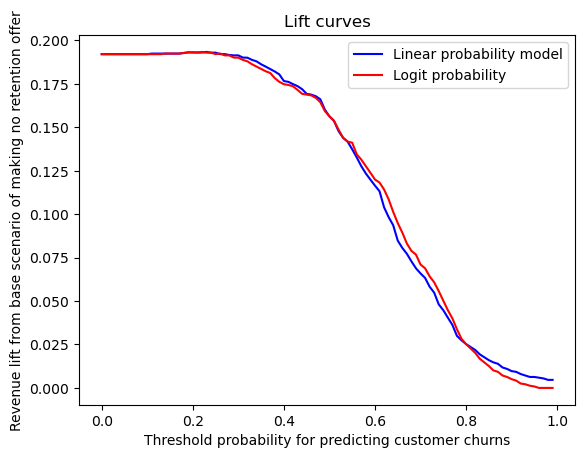

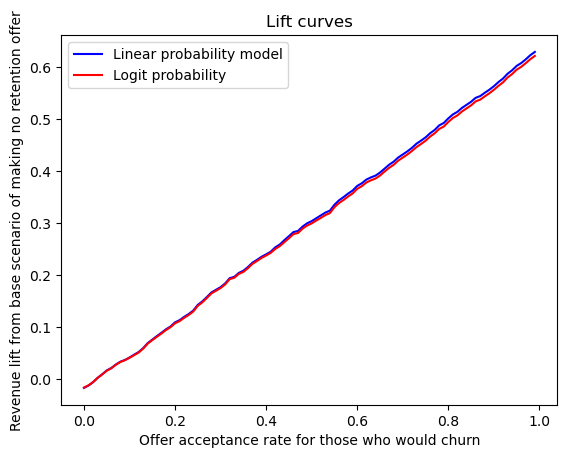

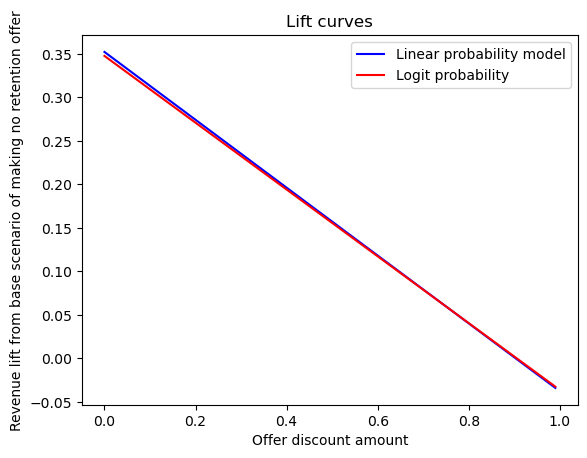

In [113]:
# Discount scenario test
no_offer = pd.DataFrame()
lpm_offer = pd.DataFrame()
logit_offer = pd.DataFrame()

for i in np.arange(0.05, 0.5, 0.05):
    t1, t2, t3 = impact_test(df_test, 0.05, 0.3, 0.4, i)
    no_offer = pd.concat([no_offer, t1])
    lpm_offer = pd.concat([lpm_offer, t2])
    logit_offer = pd.concat([logit_offer, t3])
    print('Non Churner Acceptance Rate == {}'.format(i))
    print()
    plt.plot()

In [114]:
lpm_offer

subs  revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1761  17355.0           0.325821                      0.05   
0  1778    17270           0.319328                      0.05   
0  1792  17119.0           0.307792                      0.05   
0  1771    16664           0.273033                      0.05   
0  1794  16567.5           0.265661                      0.05   
0  1797    16368            0.25042                      0.05   
0  1779  16008.5           0.222956                      0.05   
0  1795    15838           0.209931                      0.05   
0  1770  15400.5           0.176509                      0.05   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3        0.4             0.05  
0                    0.3        0.4             0.10  
0                    0.3        0.4             0.15  
0                    0.3        0.4             0.20  
0                    0.3        0.4             0.25  
0                    0.3        0.4             0.30  
0                    0.3        0.4             0.35  
0                    0.3        0.4             0.40  
0                    0.3        0.4             0.45

In [115]:
logit_offer

subs  revenue lift_from_no_offer  acceptance_rate_nonchurn  \
0  1755  17300.0            0.32162                      0.05   
0  1767    17173           0.311917                      0.05   
0  1785  17064.0           0.303591                      0.05   
0  1769    16652           0.272116                      0.05   
0  1787  16515.0            0.26165                      0.05   
0  1789    16321            0.24683                      0.05   
0  1773  15973.0           0.220244                      0.05   
0  1789    15802           0.207181                      0.05   
0  1764  15376.5           0.174675                      0.05   

   acceptance_rate_churn  threshold  discount_amount  
0                    0.3        0.4             0.05  
0                    0.3        0.4             0.10  
0                    0.3        0.4             0.15  
0                    0.3        0.4             0.20  
0                    0.3        0.4             0.25  
0                    0.3        0.4             0.30  
0                    0.3        0.4             0.35  
0                    0.3        0.4             0.40  
0                    0.3        0.4             0.45

<AxesSubplot:xlabel='discount_amount'>

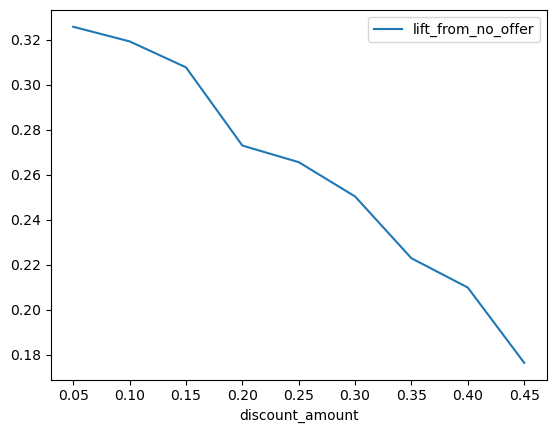

In [116]:
lpm_offer.plot(x='discount_amount', y='lift_from_no_offer')

<AxesSubplot:xlabel='discount_amount'>

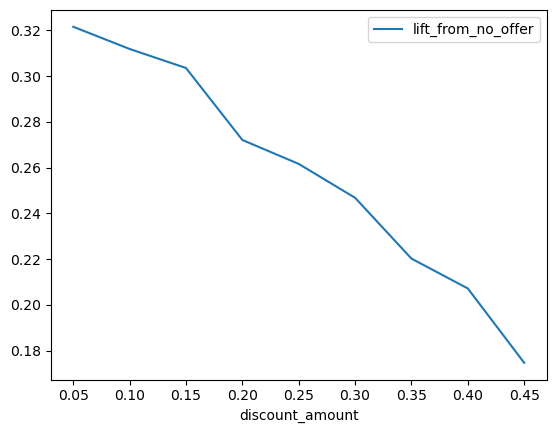

In [117]:
logit_offer.plot(x='discount_amount', y='lift_from_no_offer')